In [36]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/ubuntu/.jupyter/"
cm = BaseJSONConfigManager(config_dir=path)
cm.update('livereveal', {
              'theme': 'beige',
              'transition': 'cube',
              'start_slideshow_at': 'selected',
})

{u'start_slideshow_at': 'selected', u'theme': 'beige', u'transition': 'cube'}

In [249]:
%matplotlib inline

import matplotlib
import numpy as np

import shapely
import shapely.geometry
from shapely.geometry import shape
from shapely.geometry import Point, LineString, Polygon, MultiPolygon 
from shapely.wkt import dumps, loads
from shapely.wkb import dumps, loads
import sys
import MySQLdb
import sqlalchemy
import os
import csv
from sqlalchemy import *
from sqlalchemy.orm import *
from sqlalchemy.ext.declarative import declarative_base
import geoalchemy2
from shapely.validation import explain_validity

from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
#import pysal
import pylab as pl

In [107]:
import random


#grab a random color for coloring a figure
def get_random_color():
    r = lambda: random.randint(0,255)
    return('#%02X%02X%02X' % (r(),r(),r()))

#initialize the figure and draw the shape
def plot(shapelyGeometries, color_dict={"fill":"#AADDCC", "line":"#666666","hole_fill":"#ffffff", "hole_line":"#999999" }):
    'Plot shapelyGeometries'
    figure = pl.figure(num=None, figsize=(7, 3), dpi=180)
    axes = pl.axes()
    axes.set_aspect('equal', 'datalim')
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    
    draw(shapelyGeometries, color_dict)
            
#Check the type and break up multipolygons        
def draw(gs, color_dict):
    'Draw shapelyGeometries'
    # Handle single and lists of geometries
    try:
        gs = iter(gs)
    except TypeError:
        gs = [gs]
    #Route polygons and multipolygons to the right place
    for g in gs:
        gType = g.geom_type
        if gType.startswith('Multi') or gType == 'GeometryCollection':
            draw(g.geoms, color_dict)
        else:
            draw_(g, color_dict)

#Break the shape into its interior and exterior rings            
def draw_(g, color_dict):

    'Draw a shapelyGeometry; thanks to Sean Gilles'
    gType = g.geom_type
    if gType == 'Point':
        pl.plot(g.x, g.y, 'k,')
    elif gType == 'LineString':
        x, y = g.xy
        pl.plot(x, y, 'b-', color=color_dict["line"])
    elif gType == 'Polygon':
        #can draw parts as multiple colors
        if not color_dict:
            color_dict={"fill":get_random_color(), 
                        "line":"#666666",
                        "hole_fill":"#FFFFFF", 
                        "hole_line":"#999999" }
    
    
        x, y = g.exterior.xy
        pl.fill(x, y, color=color_dict["fill"], aa=True) 
        pl.plot(x, y, color=color_dict["line"], aa=True, lw=1.0)
        for hole in g.interiors:
            x, y = hole.xy
            pl.fill(x, y, color=color_dict["hole_fill"], aa=True) 
            pl.plot(x, y, color=color_dict["hole_line"], aa=True, lw=1.0)
            

# Geospatial Analytics in Python

&nbsp;
### Alison Alvarez
### CEO and Co-Founder of BlastPoint
    

## Let's start with a puzzle:
<IMG SRC="Georgia.png">

## Why care about geospatial data?

- Existing tools are pretty terrible and expensive

- Geospatial skills are rare and valuable

- It's an intuitive and incredibly powerful way of understanding the world

## Check out this election map, for example:

<IMG SRC=2013_results.png>

 ## Maps are great storytelling tools
 <IMG SRC="map_final.png">

## Why am I qualified to talk about this?

- I spent years building big data tools for giant companies

- I invented developed new ways to interact with geospatial data (we can talk about this later)

- I founded a company that uses geospatial data to make data more accessible

### Let's start with the spatial stuff and leave the 'geo' part for later.

### First, we start with a point...

POINT (-79.94710909999999 40.4082978)


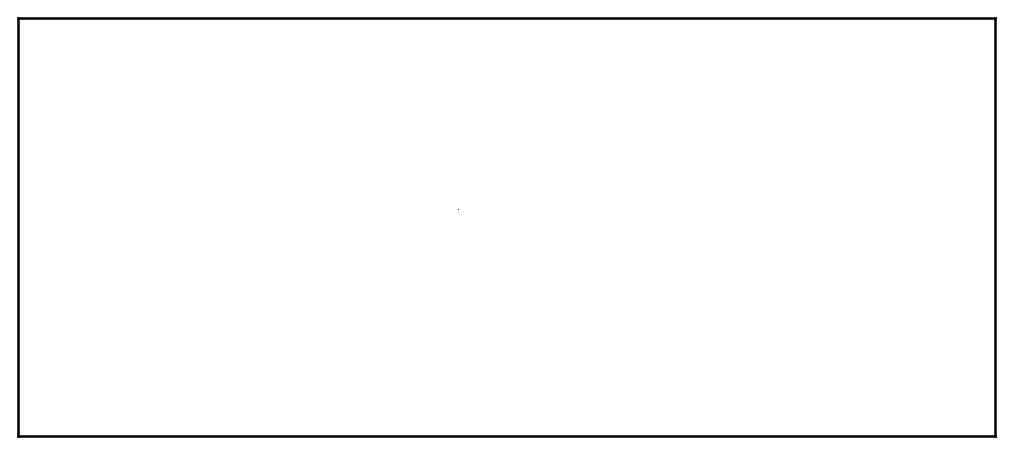

In [108]:
lat = float(40.4082978)
lng = float(-79.94710909999999)

my_point = Point(lng, lat)
print my_point
plot(my_point)

### That doesn't look like very much...

## ENHANCE!!

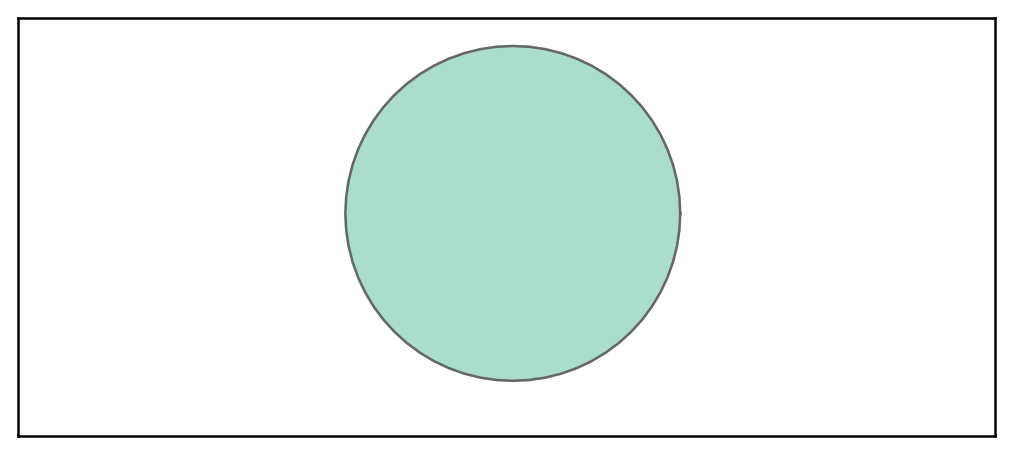

In [109]:
radius = my_point.buffer(.01)
plot(radius)

## Let's see what that looks like in text...

In [110]:
print radius

POLYGON ((-79.93710909999999 40.4082978, -79.93715725273327 40.4073176285967, -79.93730124719596 40.40634689677984, -79.93753969664267 40.40539495322746, -79.93787030467487 40.40447096567635, -79.9382898873565 40.40358383263174, -79.93879440387697 40.4027420976698, -79.93937899546637 40.40195386715836, -79.94003803218813 40.40122673218814, -79.94076516715836 40.40056769546637, -79.94155339766979 40.39998310387698, -79.94239513263173 40.39947858735652, -79.94328226567634 40.39905900467489, -79.94420625322745 40.39872839664267, -79.94515819677983 40.39848994719597, -79.94612892859669 40.39834595273328, -79.94710909999999 40.3982978, -79.94808927140329 40.39834595273328, -79.94906000322015 40.39848994719597, -79.95001194677253 40.39872839664267, -79.95093593432364 40.39905900467489, -79.95182306736825 40.39947858735652, -79.95266480233019 40.39998310387698, -79.95345303284162 40.40056769546637, -79.95418016781186 40.40122673218814, -79.95483920453361 40.40195386715836, -79.95542379612301 

## Now we've seen two types of spatial objects, here is the third: 

LINESTRING (-3 -5, 3 5)


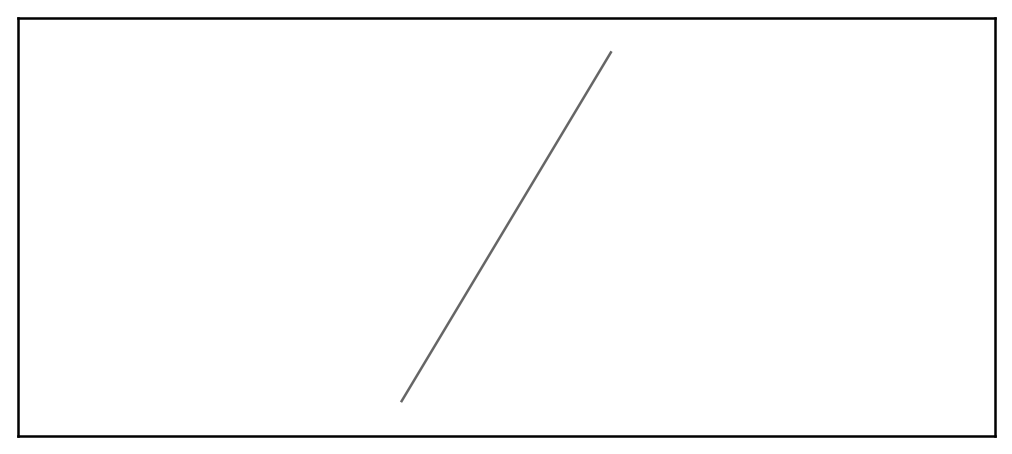

In [111]:
lineString1 = LineString(((-3, -5), (3, 5)))
print lineString1
plot(lineString1)


## There are also "multi" versions of everything: multipoint, multiline and multipolygon

## Now that we know the basics of what we have to manipulate, let's focus on shapes and look at what we can do with them.
<BR>
## First, let's talk about holes.

POLYGON ((1 1, 5 1, 5 5, 1 5, 1 1))
16.0


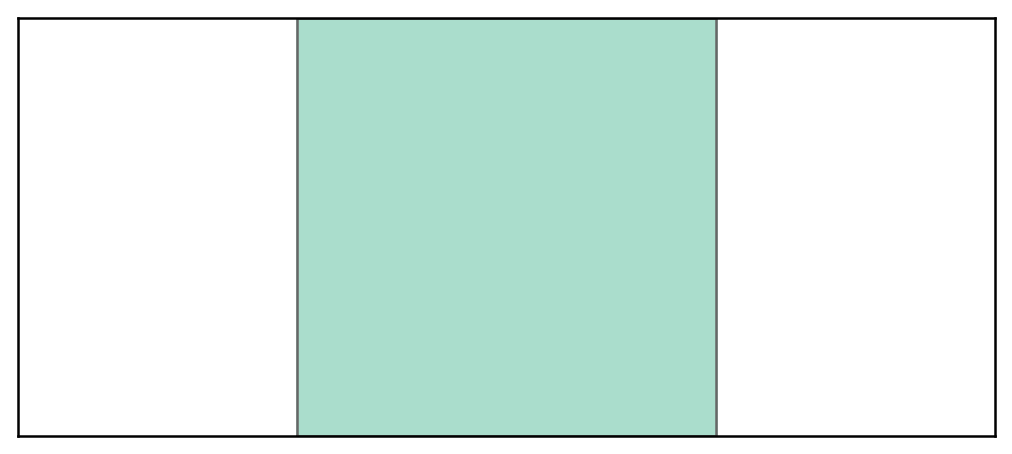

In [112]:
polygon0 = shapely.geometry.Polygon(
    ((1, 1), (5, 1), (5, 5), (1, 5), (1, 1)),      # Shell
)
print polygon0
print polygon0.area
plot(polygon0)


14.0
POLYGON ((1 1, 5 1, 5 5, 1 5, 1 1), (2 2, 2 3, 3 3, 3 2, 2 2), (3 3, 3 4, 4 4, 4 3, 3 3))


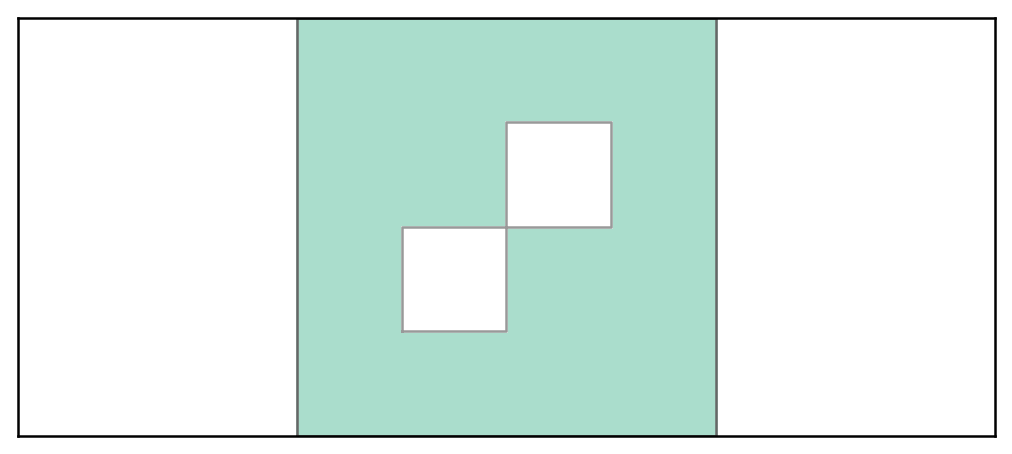

In [113]:
polygon1 = shapely.geometry.Polygon(
    ((1, 1), (5, 1), (5, 5), (1, 5), (1, 1)),      # Shell
    [
        ((2, 2), (2, 3), (3, 3), (3, 2), (2, 2)),  # Hole
        ((3, 3), (3, 4), (4, 4), (4, 3), (3, 3)),  # Hole
    ]
)
print polygon1.area
print polygon1
plot(polygon1)

You can use polygons to carve holes in other polygons.

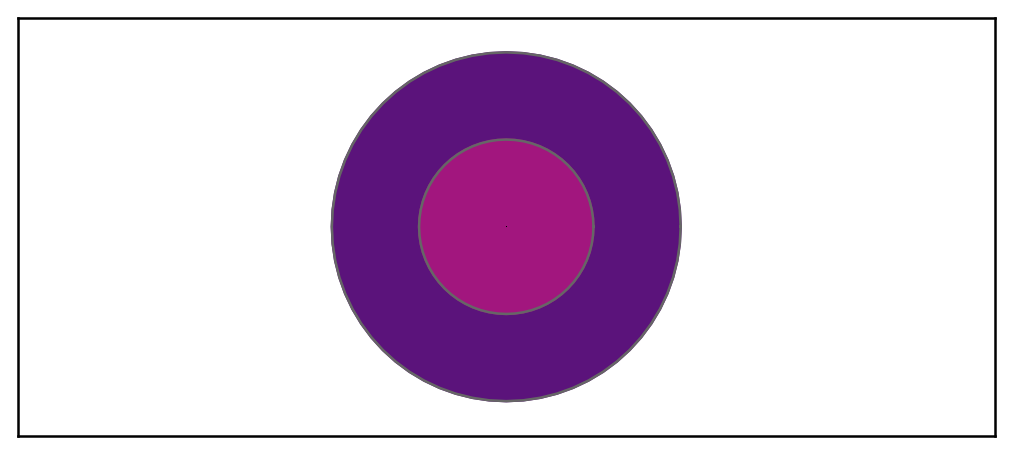

In [114]:
pt = Point(0,0)
circle =  pt.buffer(.5)
small_circle = pt.buffer(.25)
plot([circle, small_circle, pt], color_dict=None)

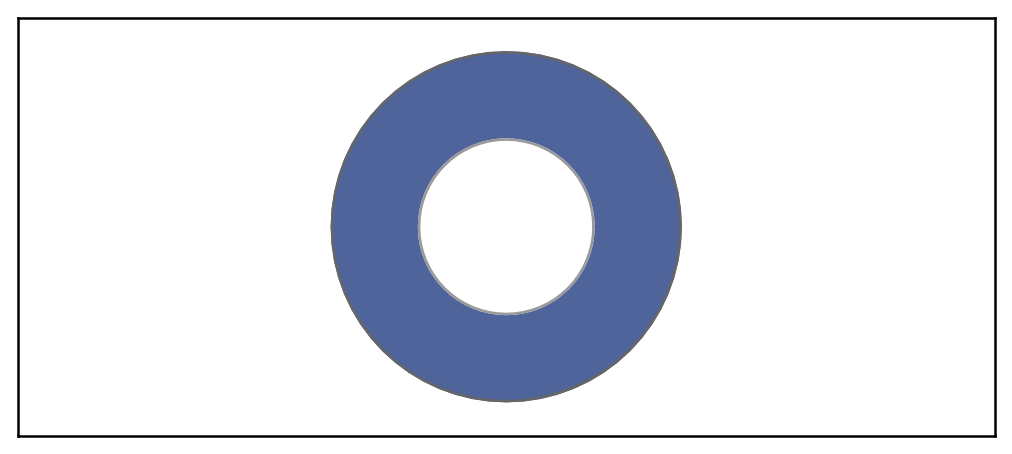

In [115]:
donut = circle.difference(small_circle)
plot(donut, color_dict=None)

## Next, you can combine polygons.
<BR>
## First, you can do a union on two shapes...

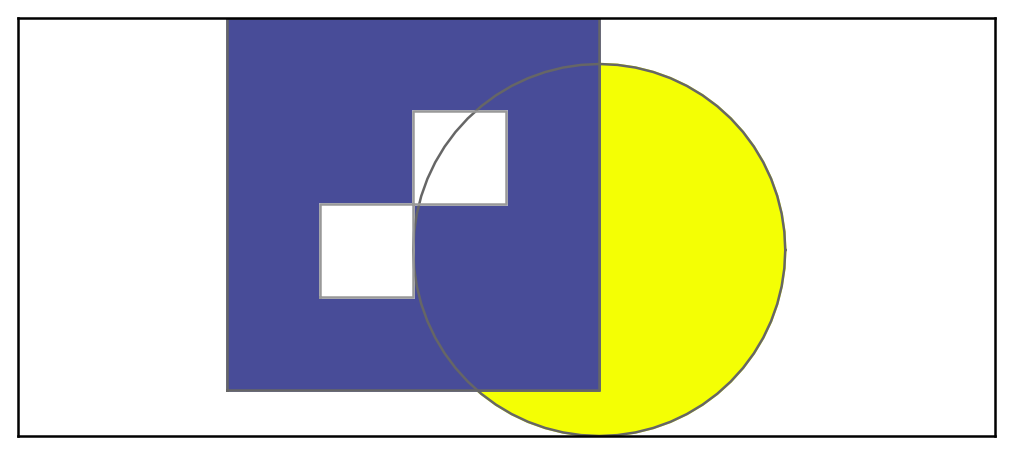

In [116]:
circle = Point(5,2.5).buffer(2)
plot([circle, polygon1], color_dict=None)

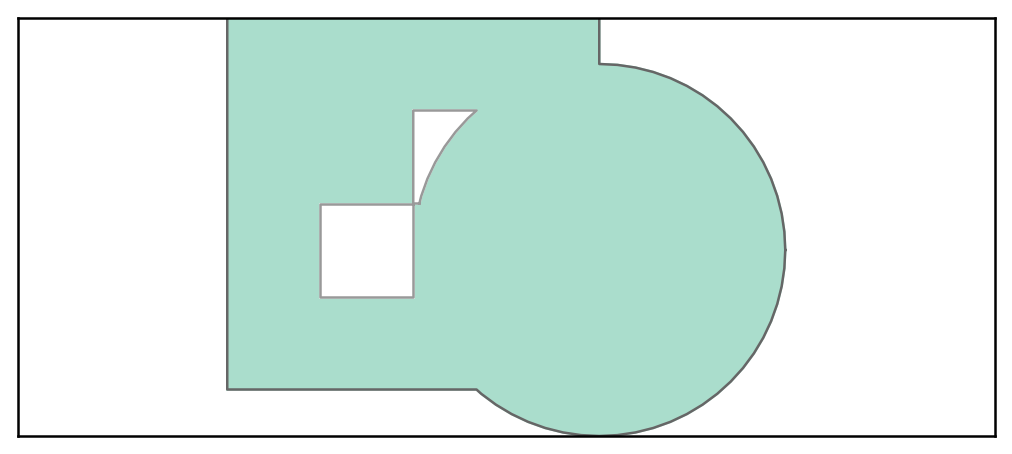

In [117]:
plot(circle.union(polygon1))

## You can also use unions to create multipolygons

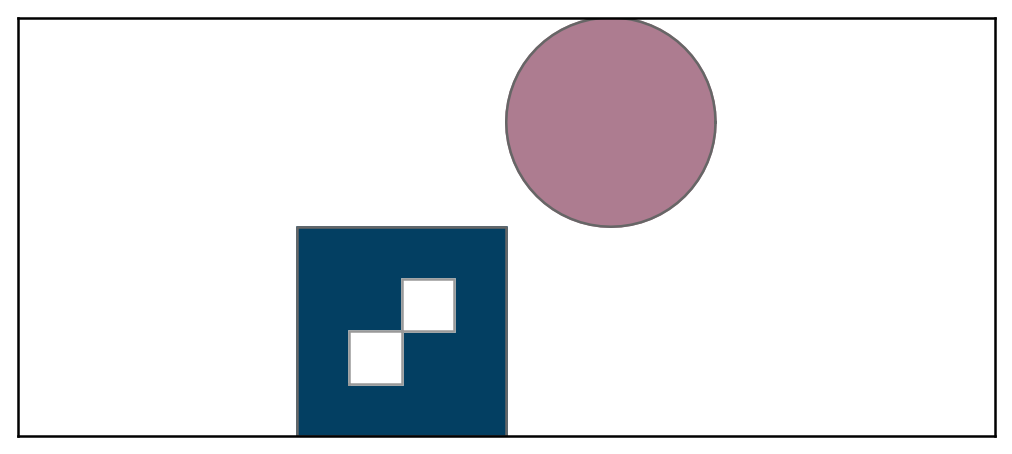

In [118]:
circle2 = Point(7,7).buffer(2)
plot([circle2, polygon1], color_dict=None)

MultiPolygon
CIRCLE AREA: 12.546194
POLYGON AREA: 14.000000
MULTIPOLYGON AREA: 26.546194


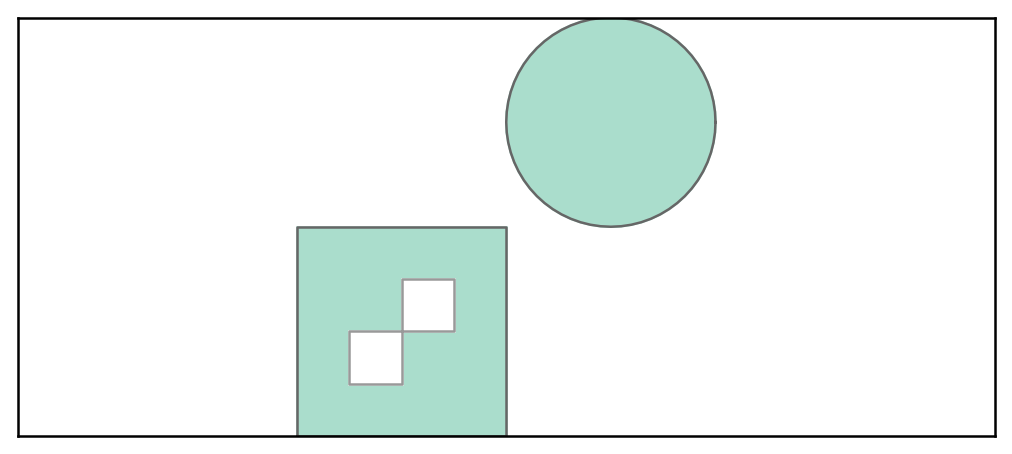

In [119]:


new_multipolygon = polygon1.union(circle2)
plot(new_multipolygon)
print new_multipolygon.type
print "CIRCLE AREA: %f" % (circle2.area)
print "POLYGON AREA: %f" % (polygon1.area)
print "MULTIPOLYGON AREA: %f" % (new_multipolygon.area)

## You can also union a bunch of shapes at once

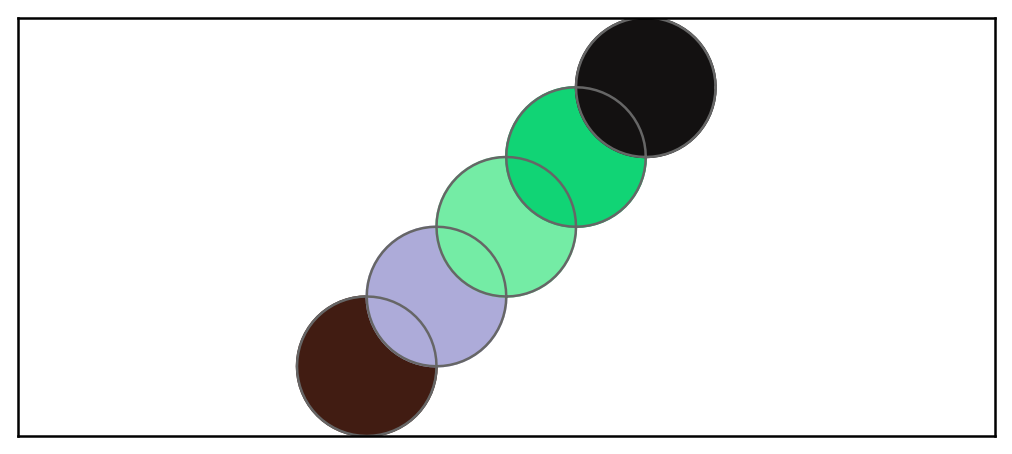

In [120]:
from shapely.ops import cascaded_union, unary_union
buffered_points_list = []

circle_set = range(5);
   
for x in circle_set:
    buffered_points_list.append(Point(x,x).buffer(1))


plot(buffered_points_list, color_dict=None)

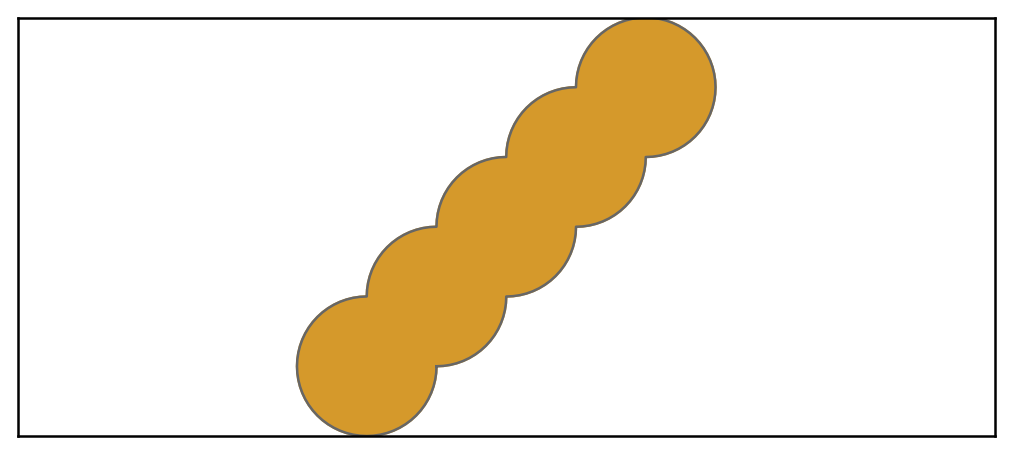

In [121]:
union_shape = cascaded_union(buffered_points_list)
plot(union_shape, color_dict=None)

## You can also create new shapes from intersections, which is incredibly useful for measuring the extent of overlap

3.13654849055


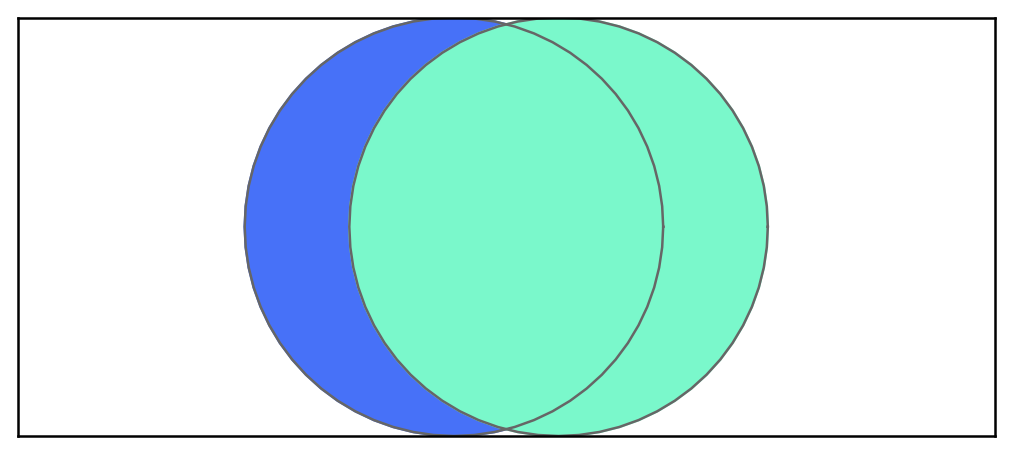

In [122]:
circle_a = Point(0,0).buffer(1)
circle_b = Point(.5,0).buffer(1)
print circle_a.area
plot([circle_a, circle_b], color_dict=None)

2.147888554


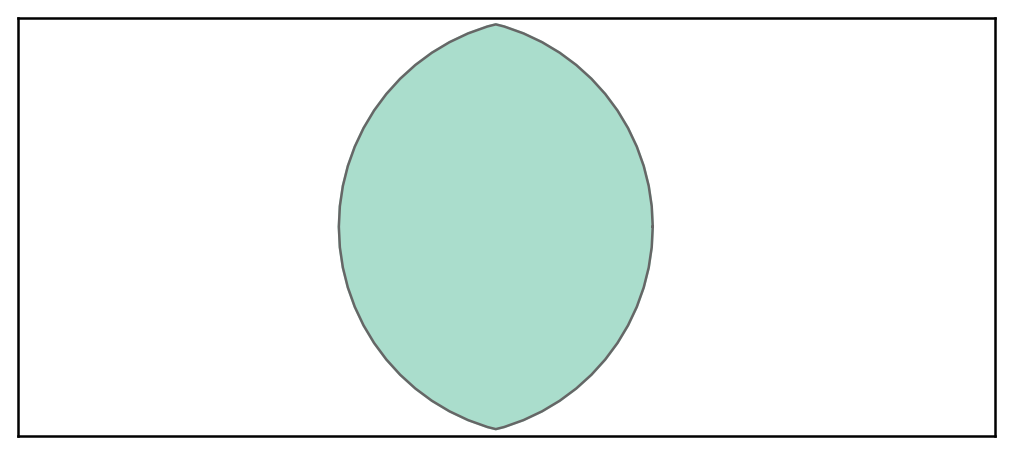

In [123]:
overlap = circle_a.intersection(circle_b)
print overlap.area
plot(overlap)


## There are also a bunch of informational functions that will tell you about the relationship of two shapes

True


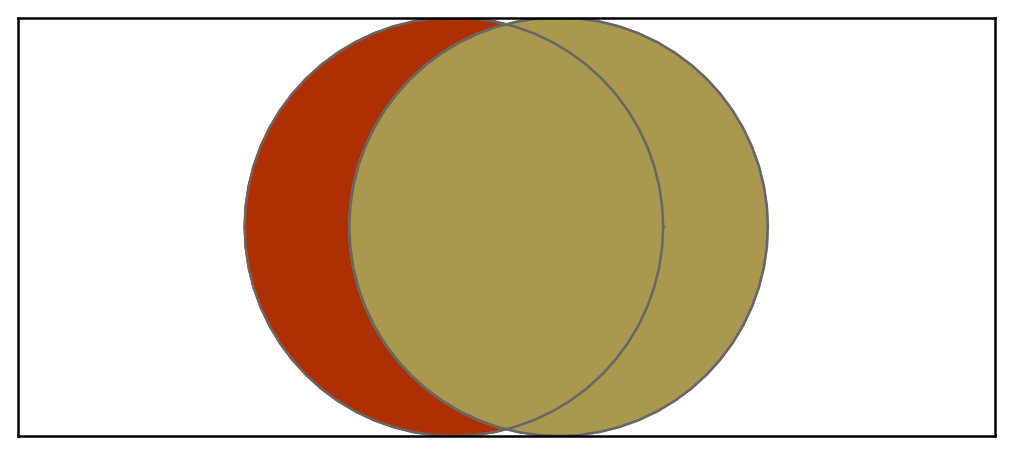

In [124]:
print circle_a.overlaps(circle_b)
plot([circle_a, circle_b], color_dict=None)

False


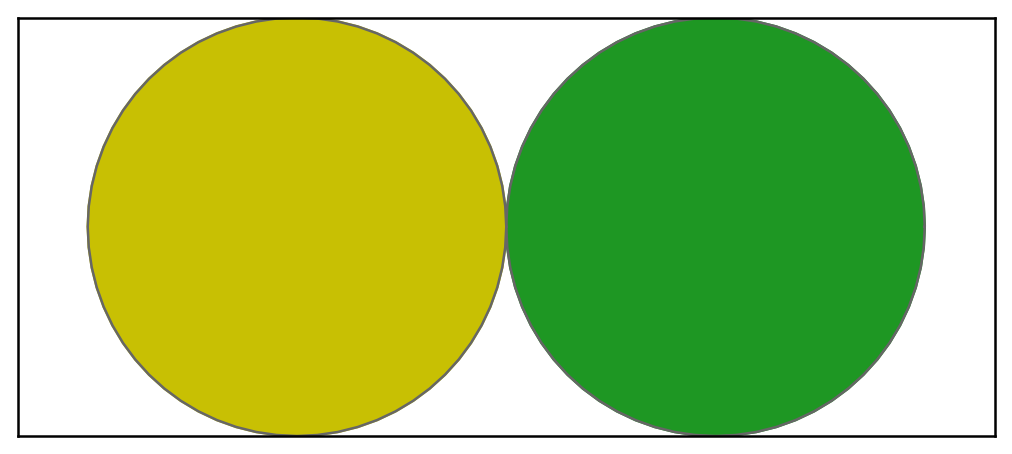

In [250]:
circle_c = Point(2,0).buffer(1)

print circle_a.overlaps(circle_c)
plot([circle_a, circle_c], color_dict=None)

False


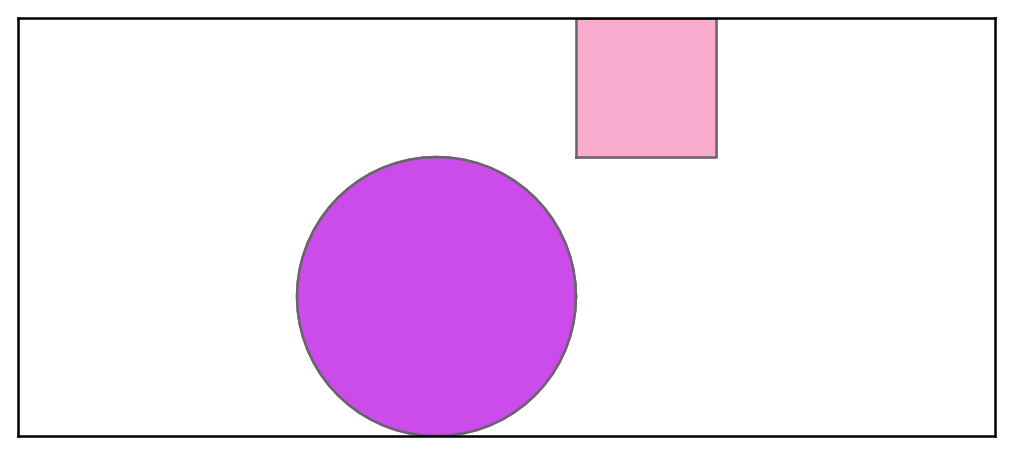

In [126]:
square = shapely.geometry.Polygon(
    ((1, 1), (2, 1), (2, 2), (1, 2), (1, 1)),      # Shell
)
print circle_a.touches(square)
plot([circle_a, square], color_dict=None)

True


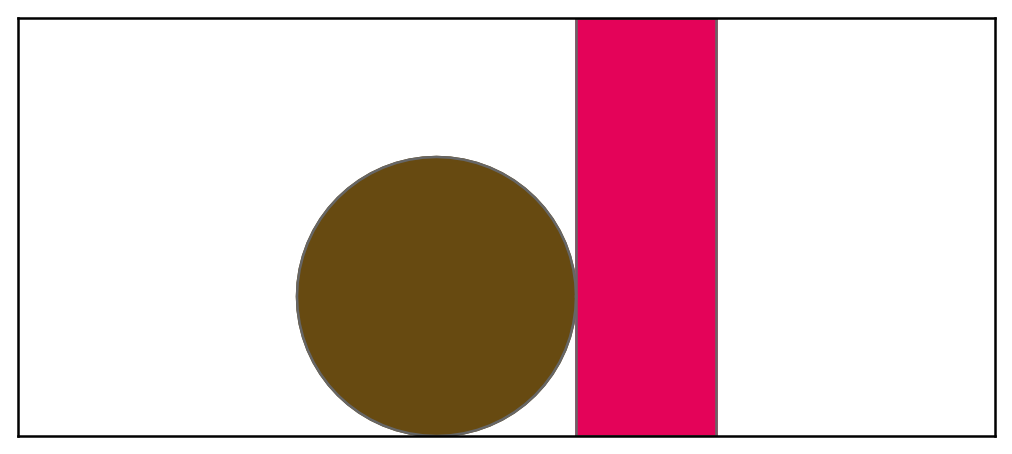

In [127]:
square = shapely.geometry.Polygon(
    ((1, -1), (2, -1), (2, 2), (1, 2), (1, -1)),      # Shell
)
print circle_a.touches(square)
plot([circle_a, square], color_dict=None)

False


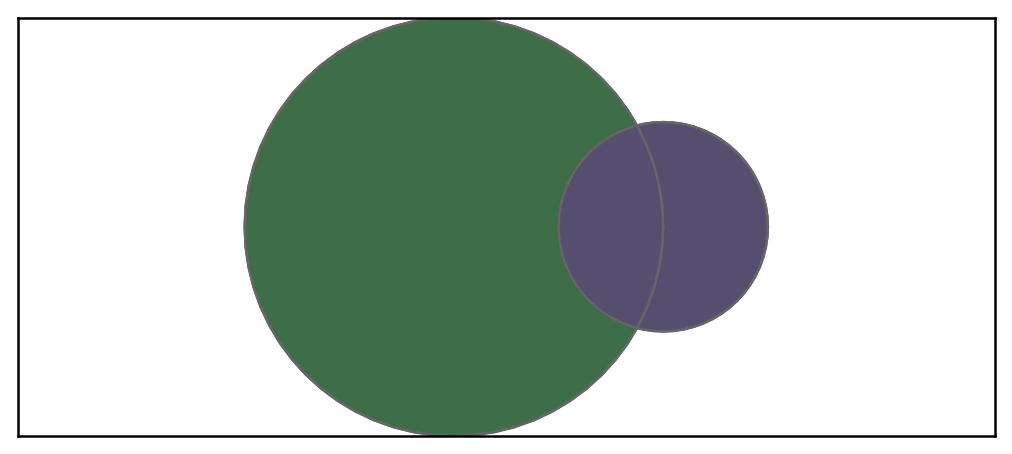

In [128]:
circle_d = Point(1,0).buffer(.5)
print circle_b.within(circle_a)
plot([circle_a, circle_d], color_dict=None)

True


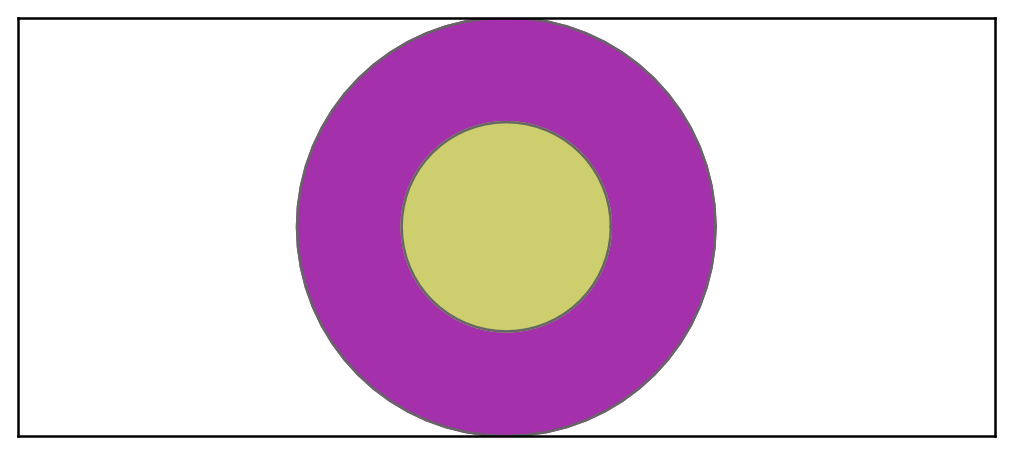

In [129]:
circle_e = Point(0,0).buffer(.5)
print circle_e.within(circle_a)
plot([circle_a, circle_e], color_dict=None)

## Next, let's talk about simplification.
<BR>
## One of the dangerous things about using 2-D space is that there are a lot of N^2 algorithms, so you need to be clever about keeping computation time down.
<BR>
## One way is to simplify shapes and take down the number of points.

## We are going to pause here and take in our first shape dataset, US states.
<BR>
## We'll load them using a handy package called Fiona that can read shapefiles.  There are from the US Census bureau. 
<BR>
## I'll save them in a dictionary with the key as the state name.

In [160]:
import fiona
def get_from_fiona(filename, id_attr):
    
    from shapely.geometry import shape

    data = {}

    c = fiona.open(filename, 'r')
    for shape_data in c:
        name =  shape_data['properties'][id_attr]
        parsed_shape = shape(shape_data['geometry'])
        
        data[name] = parsed_shape

    return data

In [168]:
#This function will help total up a count of all exterior ring points in a polygon or multipolygon
def points(s):
    if s.type == 'Polygon':
        return len(s.exterior.coords)
    if s.type == 'Point':
        return s
    else:
        x = 0
        for g in s.geoms:
            if g.type != 'Point' and g.type != 'LineString':
                x += len(g.exterior.coords)
        return x

Points: 5277


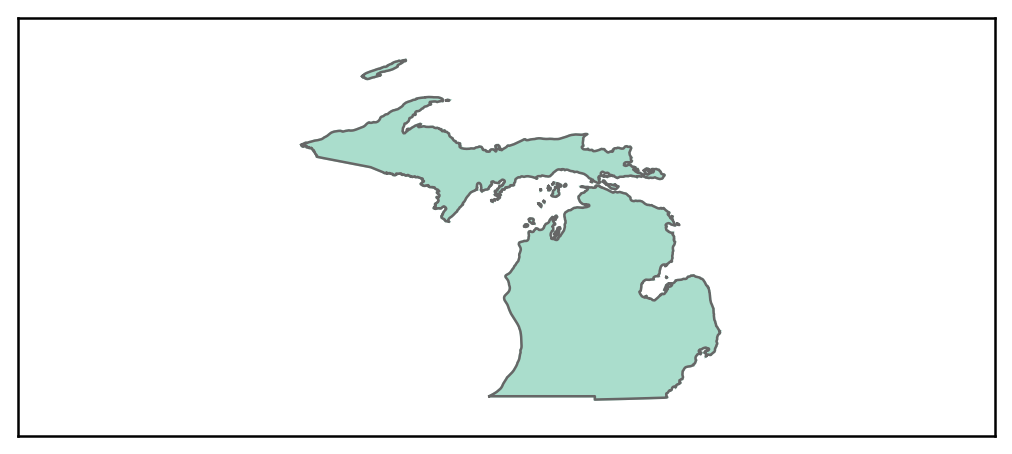

In [170]:
state_dict = get_from_fiona("data/cb_2013_us_state_500k.shp", "NAME")

michigan = state_dict["Michigan"]
print "Points: " + str(points(michigan))
plot(michigan)

## Here is what some of the internal data looks like

OrderedDict([(u'STATEFP', u'04'), (u'STATENS', u'01779777'), (u'AFFGEOID', u'0400000US04'), (u'GEOID', u'04'), (u'STUSPS', u'AZ'), (u'NAME', u'Arizona'), (u'LSAD', u'00'), (u'ALAND', 294205037082), (u'AWATER', 1027846143)])
OrderedDict([(u'STATEFP', u'05'), (u'STATENS', u'00068085'), (u'AFFGEOID', u'0400000US05'), (u'GEOID', u'05'), (u'STUSPS', u'AR'), (u'NAME', u'Arkansas'), (u'LSAD', u'00'), (u'ALAND', 134772954601), (u'AWATER', 2958815561)])
OrderedDict([(u'STATEFP', u'08'), (u'STATENS', u'01779779'), (u'AFFGEOID', u'0400000US08'), (u'GEOID', u'08'), (u'STUSPS', u'CO'), (u'NAME', u'Colorado'), (u'LSAD', u'00'), (u'ALAND', 268432676592), (u'AWATER', 1170523775)])
OrderedDict([(u'STATEFP', u'09'), (u'STATENS', u'01779780'), (u'AFFGEOID', u'0400000US09'), (u'GEOID', u'09'), (u'STUSPS', u'CT'), (u'NAME', u'Connecticut'), (u'LSAD', u'00'), (u'ALAND', 12541965607), (u'AWATER', 1815409624)])
OrderedDict([(u'STATEFP', u'11'), (u'STATENS', u'01702382'), (u'AFFGEOID', u'0400000US11'), (u'GEOID', u'11'), (u'STUSPS', u'DC'), (u'NAME', u'District of Columbia'), (u'LSAD', u'00'), (u'ALAND', 158347880), (u'AWATER', 18636405)])
OrderedDict([(u'STATEFP', u'13'), (u'STATENS', u'01705317'), (u'AFFGEOID', u'0400000US13'), (u'GEOID', u'13'), (u'STUSPS', u'GA'), (u'NAME', u'Georgia'), (u'LSAD', u'00'), (u'ALAND', 148962779995), (u'AWATER', 4947803555)])
OrderedDict([(u'STATEFP', u'16'), (u'STATENS', u'01779783'), (u'AFFGEOID', u'0400000US16'), (u'GEOID', u'16'), (u'STUSPS', u'ID'), (u'NAME', u'Idaho'), (u'LSAD', u'00'), (u'ALAND', 214045724209), (u'AWATER', 2397731902)])

## Make sure you get the shapefile that is clipped to the coastline...

Points: 10624


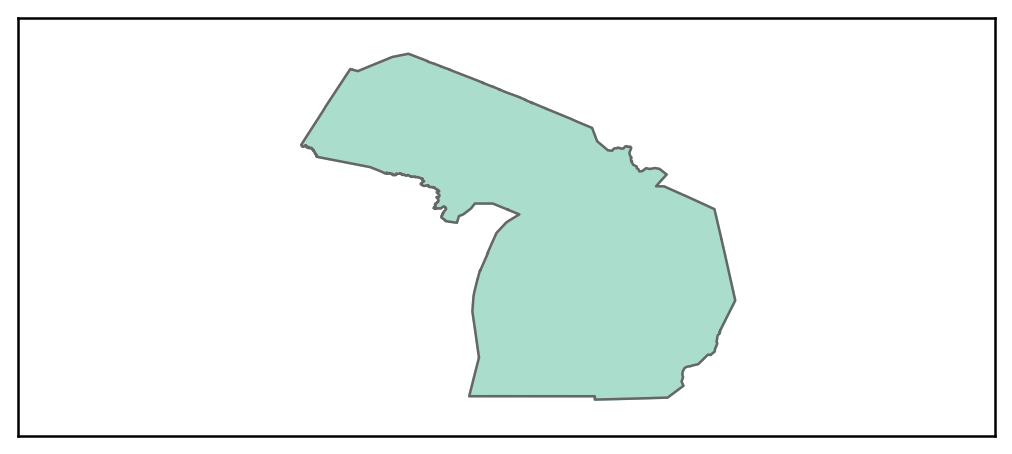

In [171]:
state_dict = get_from_fiona("data/tl_2016_us_state.dbf", "NAME")

weird_michigan = state_dict["Michigan"]
print "Points: " + str(points(weird_michigan))
plot(weird_michigan)

Points: 3154


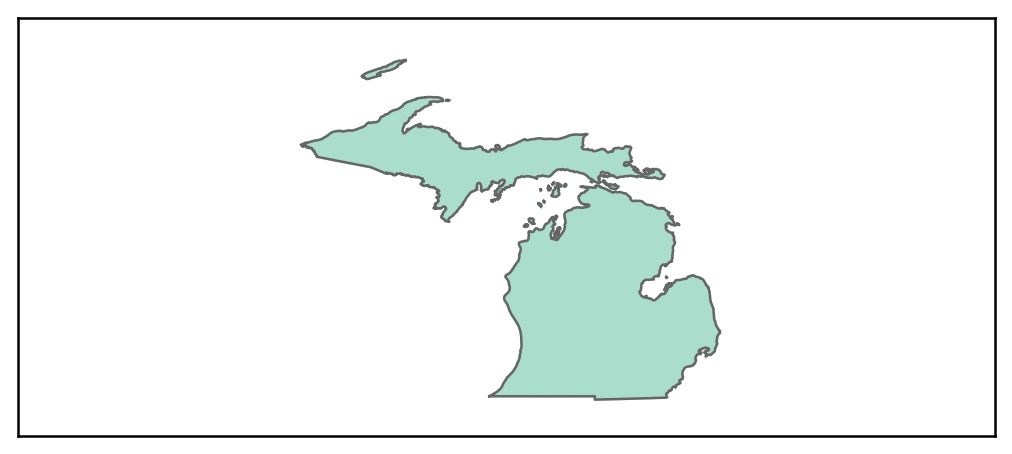

In [174]:
sim_michigan0 = michigan.simplify(0.0001)
print "Points: " + str(points(sim_michigan0))
plot(sim_michigan0)

Points: 2697


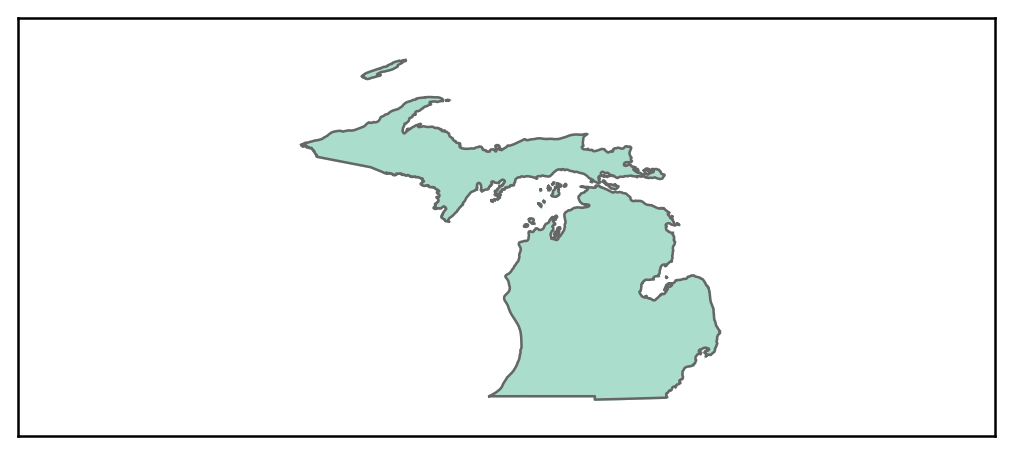

In [175]:
sim_michigan1 = michigan.simplify(0.001)
print "Points: " + str(points(sim_michigan1))
plot(sim_michigan1)

Points: 375


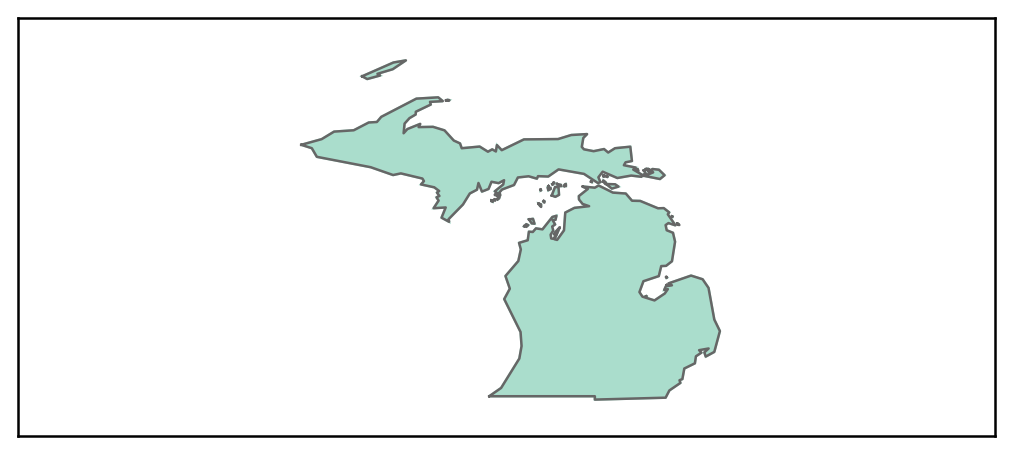

In [176]:
sim_michigan2 = michigan.simplify(0.03)
print "Points: " + str(points(sim_michigan2))
plot(sim_michigan2)


Points: 245


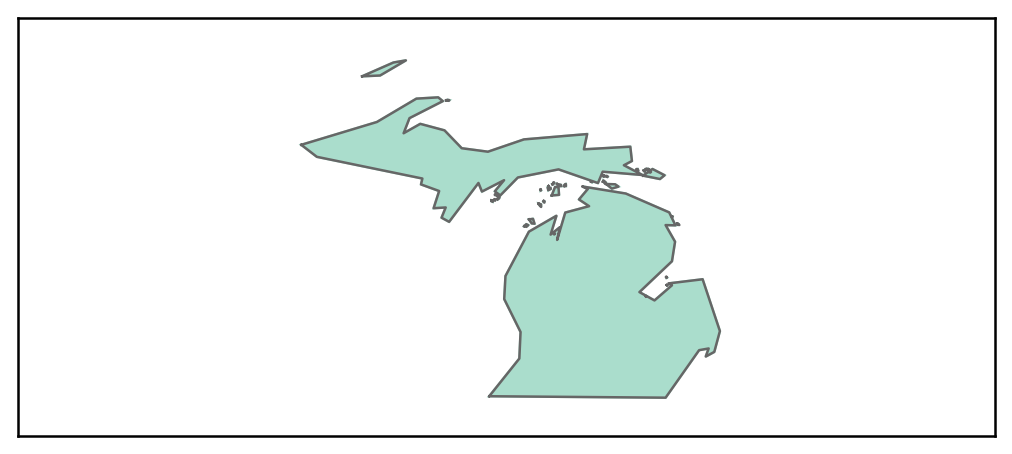

In [177]:
sim_michigan3 = michigan.simplify(0.1)
print "Points: " + str(points(sim_michigan3))
plot(sim_michigan3)

Points: 190


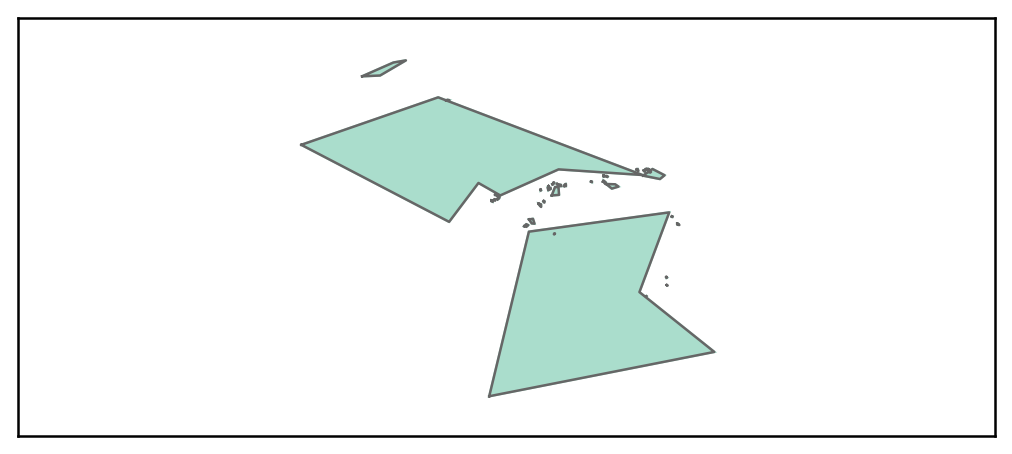

In [178]:
sim_michigan4 = michigan.simplify(1)
print "Points: " + str(points(sim_michigan4))
plot(sim_michigan4)

Points: 76


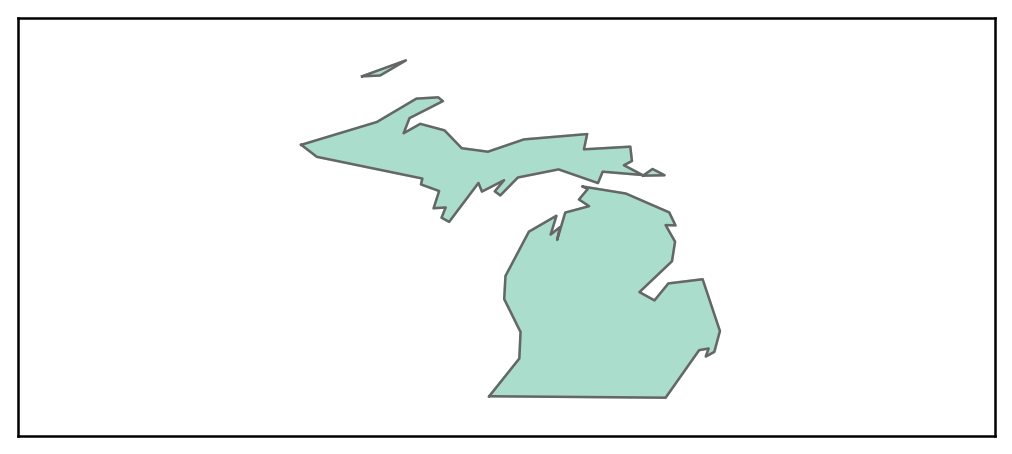

In [179]:
sim_michigan5 = michigan.simplify(.1, preserve_topology=False)
print "Points: " + str(points(sim_michigan5))
plot(sim_michigan5)



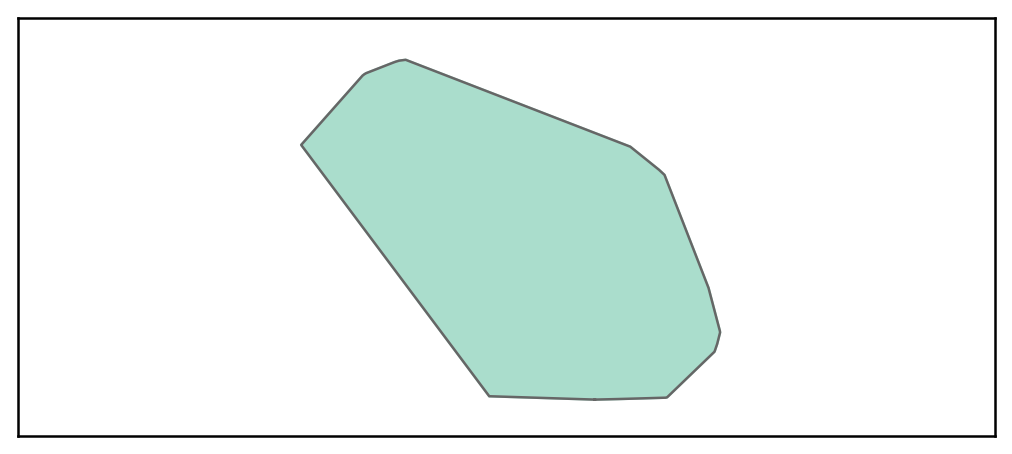

In [157]:
plot(michigan.convex_hull)

## You can also find centroids and use those for shortcuts.

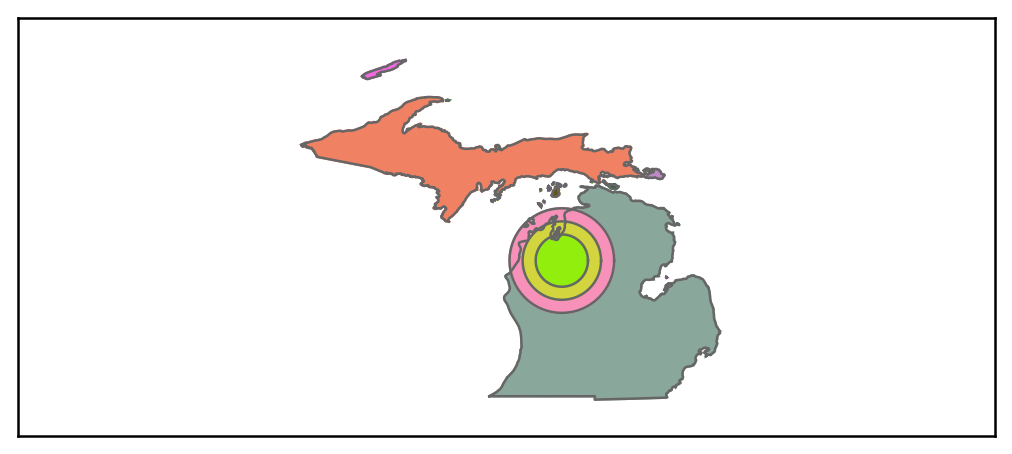

In [186]:
centroid_point = michigan.centroid
plot([michigan, centroid_point.buffer(1), centroid_point.buffer(.75), centroid_point.buffer(.5)], color_dict=None)

## Okay, one of the things with shapes and simplification is that it can "break" them, or make them invalid.
<BR>
## There are a couple of ways this can happen that can be fixed with a buffer:



Self-intersection[-5 0]


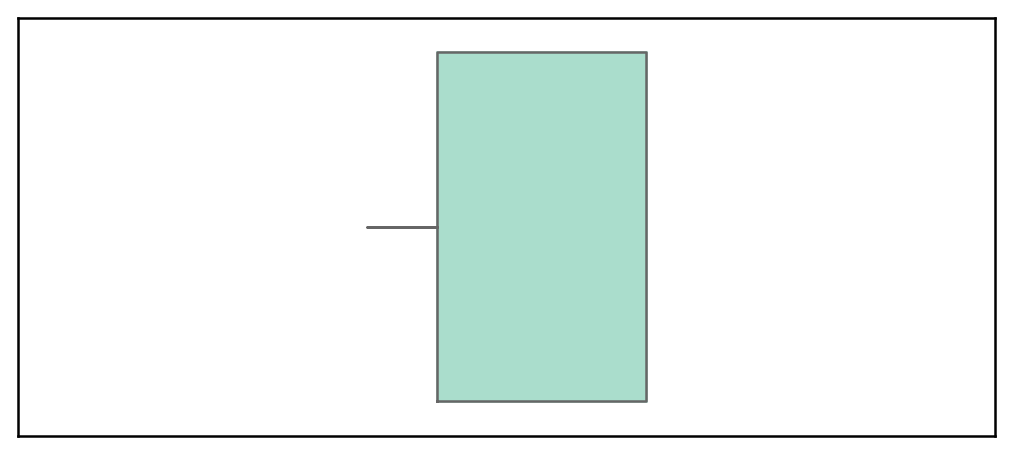

In [197]:
sad_polygon1 = shapely.geometry.Polygon(((-3, -5),(-3,0),(-5,0),(-3,0),(-3, 5),(3, 5), (3, -5), (-3, -5)))
print explain_validity(sad_polygon1)
plot(sad_polygon1)

Valid Geometry


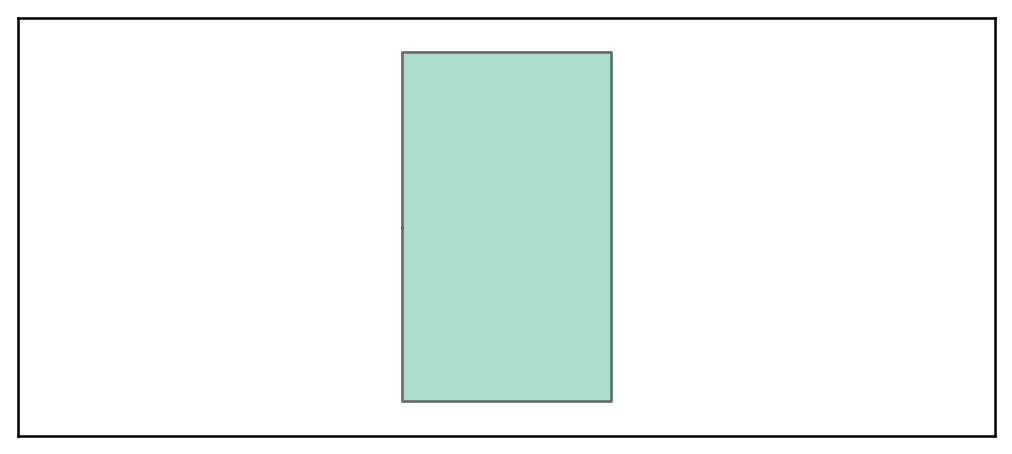

In [205]:
fixed_polygon1 = sad_polygon1.buffer(0)
print explain_validity(fixed_polygon1)
plot(fixed_polygon1)

Self-intersection[0 0]
The bowtie's area: 0.0


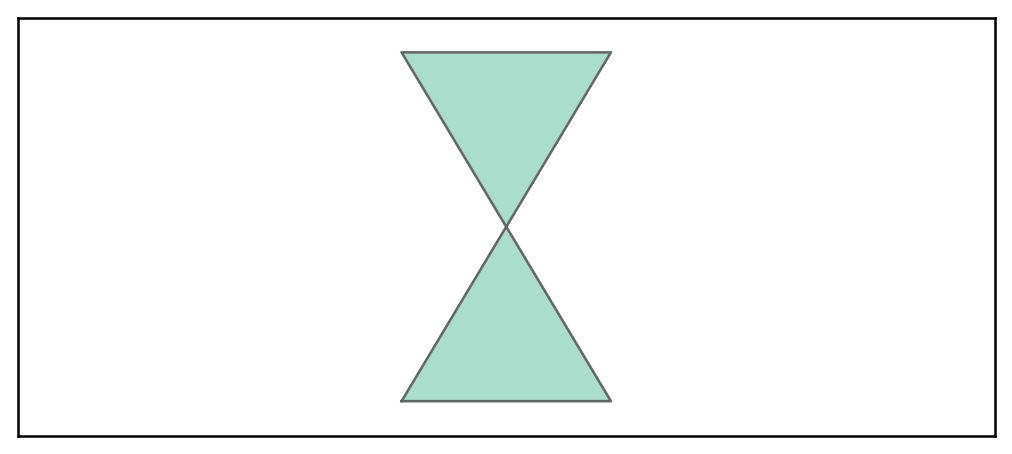

In [201]:
sad_polygon2 = shapely.geometry.Polygon(((-3, -5), (3, 5), (-3, 5), (3, -5), (-3, -5)))
plot(sad_polygon2)
print explain_validity(sad_polygon2)
print "The bowtie's area: " + str(sad_polygon2.area)

Valid Geometry
POLYGON ((0 0, -3 5, 3 5, 0 0))
The area of our fixed shape:15.0


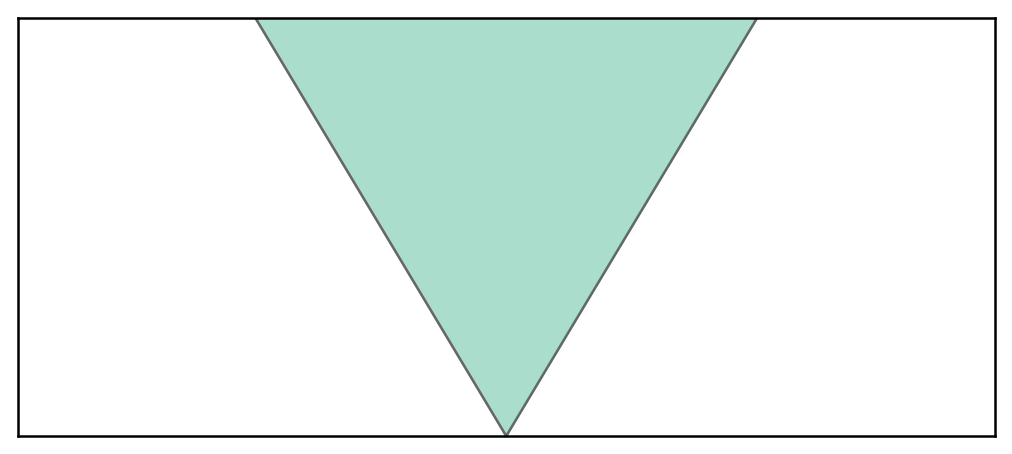

In [202]:
fixed_polygon2 = sad_polygon2.buffer(0)
plot(fixed_polygon2)
print explain_validity(fixed_polygon2)
print fixed_polygon2
print "The area of our fixed shape:" + str(fixed_polygon2.area)

Hole lies outside shell[6 6]
SAD POLYGON AREA: 14.000000


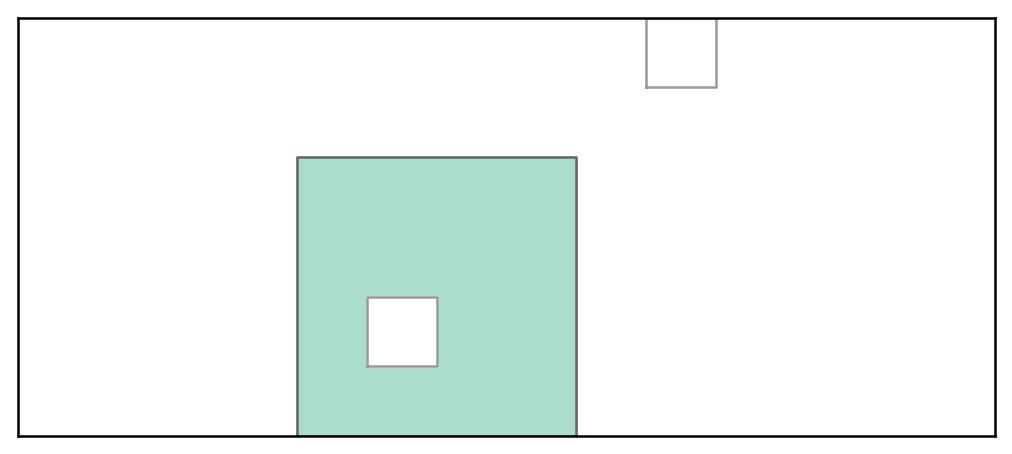

In [206]:
sad_polygon3 = shapely.geometry.Polygon(
    ((1, 1), (5, 1), (5, 5), (1, 5), (1, 1)),      # Shell
    [
        ((2, 2), (2, 3), (3, 3), (3, 2), (2, 2)),  # Hole
        ((6, 6), (6, 7), (7, 7), (7, 6), (6, 6)),  # Hole
    ]
)
plot(sad_polygon3)
print explain_validity(sad_polygon3)
print "SAD POLYGON AREA: %f" % (sad_polygon3.area)

Valid Geometry
FIXED POLYGON AREA: 15.000000


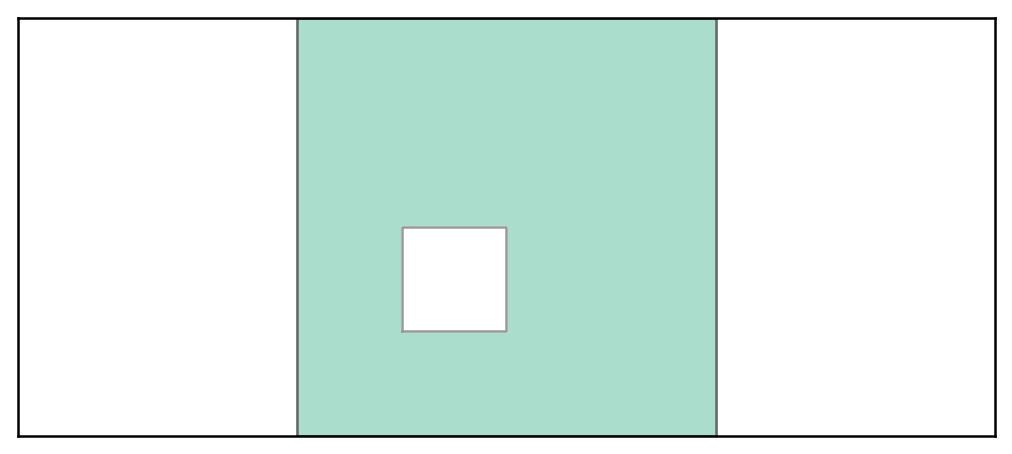

In [207]:
fixed_polygon3 = sad_polygon3.buffer(0)
plot(fixed_polygon3)
print explain_validity(fixed_polygon3)
print "FIXED POLYGON AREA: %f" % (fixed_polygon3.area)

Holes are nested[3 3]
SAD POLYGON AREA: 11.750000


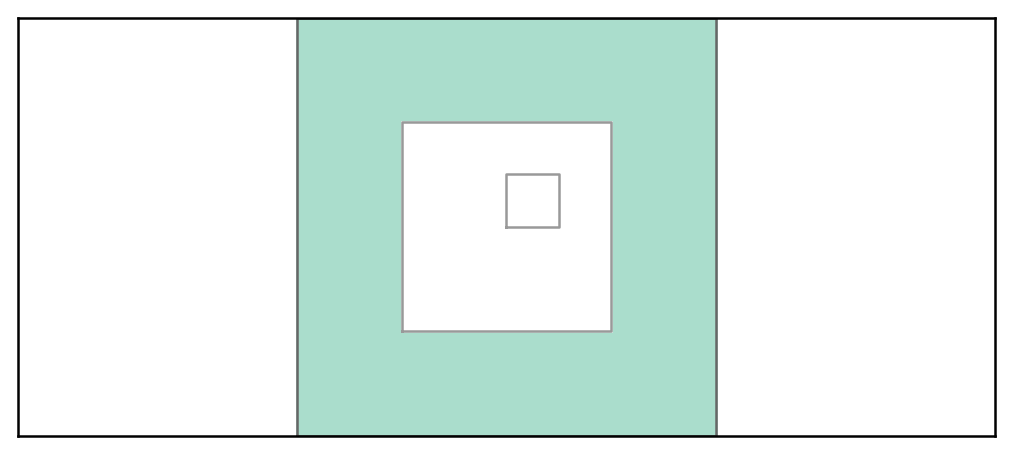

In [208]:
sad_polygon4 = shapely.geometry.Polygon(
    ((1, 1), (5, 1), (5, 5), (1, 5), (1, 1)),      # Shell
    [
        ((2, 2), (2, 4), (4, 4), (4, 2), (2, 2)),  # Hole
        ((3, 3), (3, 3.5), (3.5, 3.5), (3.5, 3), (3, 3)),  # Hole
    ]
)
plot(sad_polygon4)
print explain_validity(sad_polygon4)
print "SAD POLYGON AREA: %f" % (sad_polygon4.area)

Valid Geometry
FIXED POLYGON AREA: 12.000000


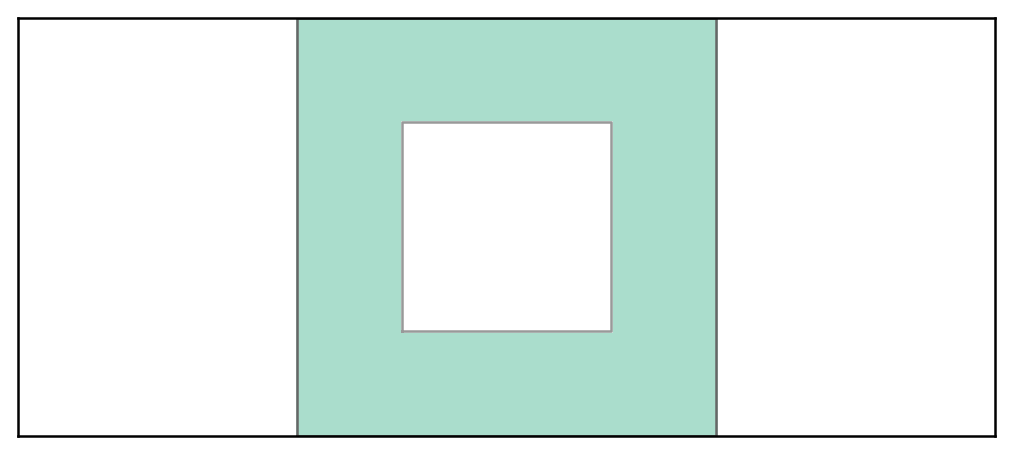

In [210]:
fixed_polygon4 = sad_polygon4.buffer(0)
plot(fixed_polygon4)
print explain_validity(fixed_polygon4)
print "FIXED POLYGON AREA: %f" % (fixed_polygon4.area)

## There is one error that is better if treated differently: polygons without enough points
<BR>
## You can get rid of this by traversing the rings of the polygon to find the broken piece and remove it.

Too few points in geometry component[2 2]


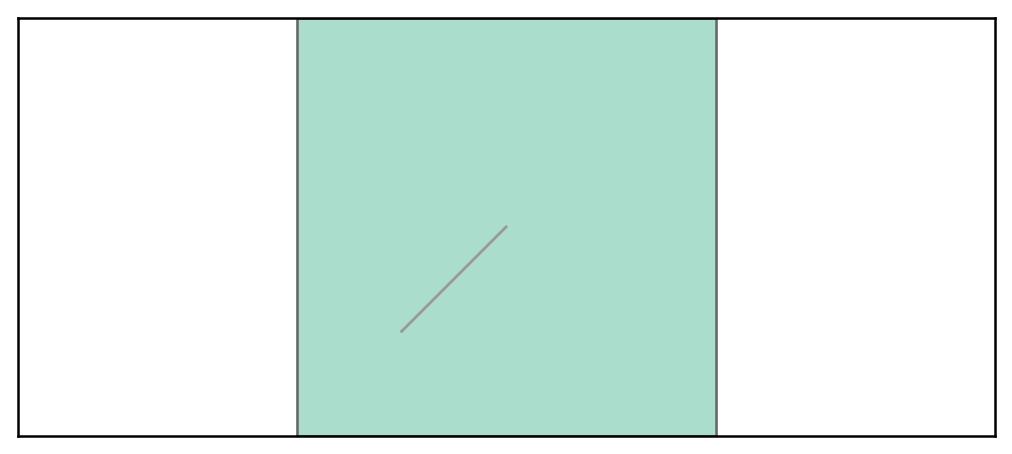

In [211]:
sad_polygon6 = shapely.geometry.Polygon(
    ((1, 1), (5, 1), (5, 5), (1, 5), (1, 1)),      # Shell
    [
        ((2, 2), (2, 2), (3, 3), (3, 3), (2, 2)),  # Hole
    ]
)
plot(sad_polygon6)
print explain_validity(sad_polygon6)

In [224]:
def remove_bad_shapes(shape):
    if shape.type == 'Multipolygon':
        shape_list = shape.geoms
    elif shape.type == 'Polygon':
        shape_list = [shape]
    else:
        return None
    
    polygon_list = []
    
    for g in shape_list:
        print g
        print explain_validity(g)

        hole_list = []
        for hole in g.interiors:
            hole_shape = shapely.geometry.Polygon(hole)

            if "Too few points" not in explain_validity(hole_shape):
                hole_list.append(hole)
            else:
                print "Removed hole: "
                print "\t" + str(hole)


        if "Too few points" not in explain_validity(shapely.geometry.Polygon(g.exterior.coords)):
            print "\t" + explain_validity(shapely.geometry.Polygon(g.exterior.coords))
            polygon_list.append(shapely.geometry.Polygon(g.exterior.coords, hole_list))
        else:
            print "Removed: " 
            print "\t" + str(g.exterior.coords)
            
    return shapely.geometry.MultiPolygon(polygon_list)

POLYGON ((1 1, 5 1, 5 5, 1 5, 1 1), (2 2, 2 2, 3 3, 3 3, 2 2))
Too few points in geometry component[2 2]
Removed hole: 
	LINEARRING (2 2, 2 2, 3 3, 3 3, 2 2)
	Valid Geometry

The validity of the fixed shape:
Valid Geometry


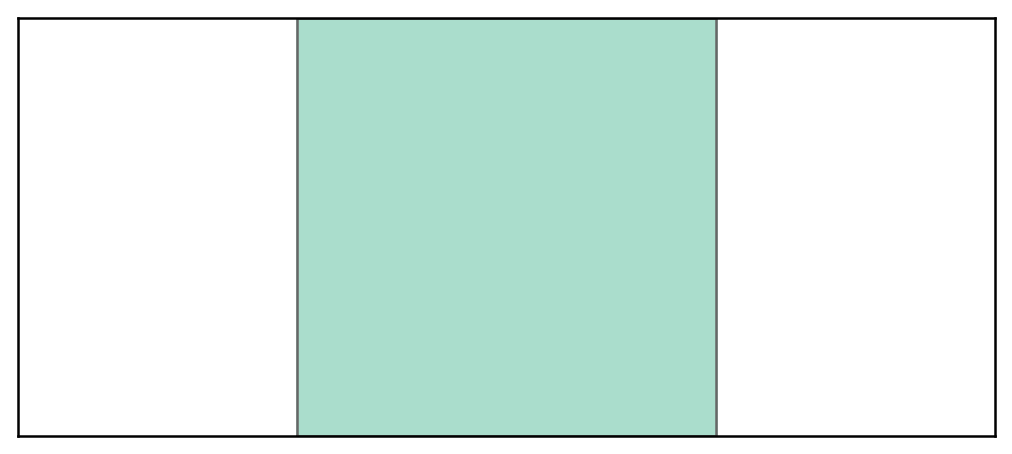

In [225]:
fixed_polygon6 = remove_bad_shapes(sad_polygon6)
plot(fixed_polygon6)

print "\nThe validity of the fixed shape:"
print explain_validity(fixed_polygon6)

## There are some great resources for shapes and segments out there.  I've pulled local stuff from the Western PA Regional Data Center.
<BR>
## Also, the US Census Bureau is a candy store of free shape data.  You can find anything from the whole US all the way down to census block groups.
<BR>


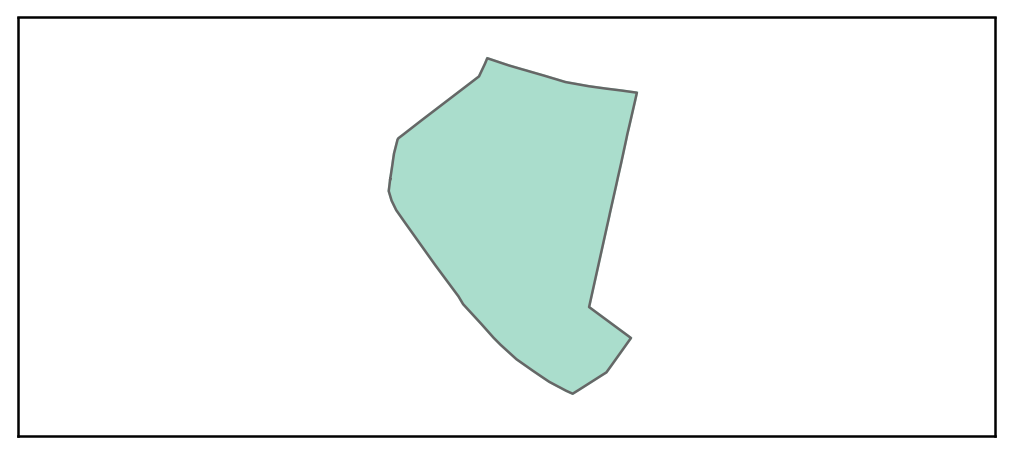

In [232]:
CBG= shapely.wkt.loads(
"POLYGON ((-79.958496 40.432523, -79.958483 40.432604, -79.958446 40.432849, -79.95843499999999 40.432931, -79.95841299999999 40.433076, -79.958337 40.433375, -79.958319 40.433403, -79.958214 40.433483, -79.957835 40.433778, -79.95673699999999 40.434617, -79.956586 40.434733, -79.956457 40.435006, -79.956408 40.43512399999999, -79.95631299999999 40.435092, -79.95603199999999 40.434998, -79.955938 40.434967, -79.955866 40.434946, -79.95564999999999 40.434883, -79.955578 40.434863, -79.9555 40.43484, -79.95526799999999 40.434773, -79.955191 40.434751, -79.95513799999999 40.434735, -79.954982 40.434688, -79.95492999999999 40.434673, -79.95486199999999 40.434652, -79.954729 40.434612, -79.95465899999999 40.434599, -79.95459 40.434587, -79.95431099999999 40.434537, -79.95421999999999 40.434521, -79.95386599999999 40.434472, -79.953497 40.43442599999999, -79.95347099999999 40.434422, -79.95319099999999 40.434383, -79.953214 40.434281, -79.953231 40.434204, -79.95335399999999 40.43367, -79.953396 40.433493, -79.953419 40.433382, -79.95349 40.433052, -79.953514 40.432942, -79.95353 40.432867, -79.953581 40.432642, -79.953598 40.432568, -79.953632 40.43241099999999, -79.953738 40.43194099999999, -79.953773 40.431785, -79.953783 40.431736, -79.95381499999999 40.43159199999999, -79.95382599999999 40.431544, -79.95421899999999 40.429773, -79.95377499999999 40.429445, -79.953683 40.429377, -79.95366 40.42936, -79.95340899999999 40.429175, -79.953373 40.429148, -79.95331899999999 40.42910699999999, -79.953424 40.428959, -79.95374 40.42851599999999, -79.953846 40.428369, -79.953991 40.428277, -79.954425 40.42800099999999, -79.954571 40.42791, -79.95462599999999 40.427934, -79.954714 40.427974, -79.954791 40.42801499999999, -79.95484499999999 40.428044, -79.95488999999999 40.428067, -79.95507599999999 40.428166, -79.95525599999999 40.428287, -79.955428 40.428404, -79.95577999999999 40.428651, -79.95612199999999 40.428962, -79.956272 40.429113, -79.956535 40.429409, -79.95692699999999 40.429835, -79.957027 40.430003, -79.957527 40.430676, -79.958168 40.431576, -79.958366 40.431858, -79.958466 40.432064, -79.95852699999999 40.432268, -79.958496 40.432523))"
)
plot(CBG)

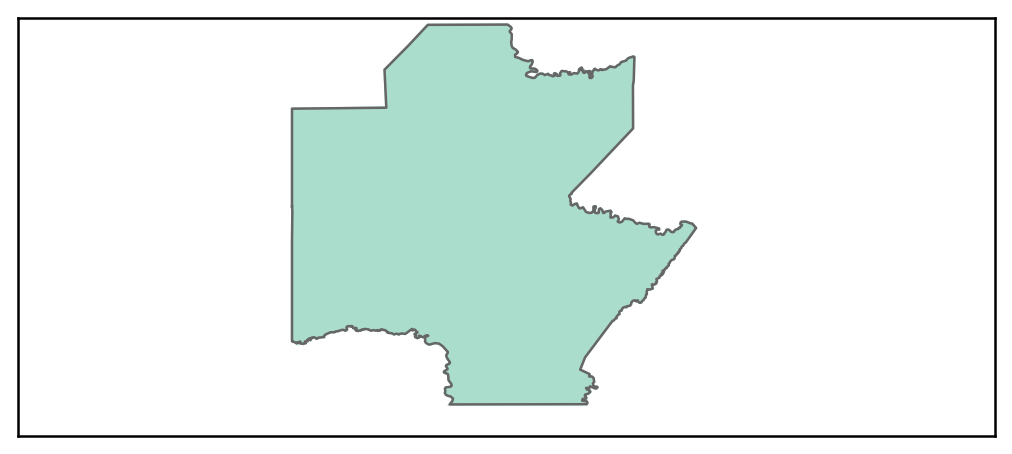

In [229]:
CBSA = shapely.wkt.loads(
"POLYGON((-80.51903799999999 40.477363,-80.51904399999999 40.851339,-80.158534 40.855157,-80.16529 41.00047,-80.074422 41.092292,-79.99977899999999 41.171861,-79.69498399999999 41.172865,-79.683627 41.16485,-79.679604 41.159646,-79.680244 41.155741,-79.686151 41.14881,-79.686719 41.145077,-79.679633 41.137118,-79.67877299999999 41.133351,-79.67937499999999 41.114783,-79.68133999999999 41.106589,-79.67930199999999 41.091153,-79.67528899999999 41.08365999999999,-79.663962 41.077426,-79.65552699999999 41.06842899999999,-79.657223 41.064002,-79.666579 41.057149,-79.66595 41.049347,-79.651257 41.045057,-79.63632 41.037763,-79.619365 41.033348,-79.61366699999999 41.033349,-79.60539399999999 41.036933,-79.60118 41.036874,-79.59898699999999 41.033807,-79.59952899999999 41.029432,-79.60269699999999 41.020653,-79.60901199999999 41.012642,-79.60945799999999 41.00721799999999,-79.606708 41.005181,-79.590164 41.004028,-79.581774 40.997982,-79.58157799999999 40.99404,-79.584896 40.991557,-79.60481799999999 40.99459299999999,-79.619067 40.98896,-79.623491 40.98455999999999,-79.624494 40.979992,-79.622759 40.976374,-79.60121699999999 40.96928399999999,-79.595248 40.968588,-79.590091 40.969945,-79.581096 40.980418,-79.570353 40.98564,-79.560108 40.984849,-79.55262399999999 40.97978,-79.540035 40.984514,-79.535822 40.980063,-79.52861399999999 40.978413,-79.52242799999999 40.974958,-79.515232 40.977839,-79.514764 40.980251,-79.517836 40.983965,-79.51675999999999 40.986274,-79.51401199999999 40.986809,-79.50740499999999 40.98404499999999,-79.50514799999999 40.976848,-79.493658 40.977901,-79.492778 40.980888,-79.49478499999999 40.98618099999999,-79.487894 40.995583,-79.47098699999999 40.993964,-79.46320299999999 40.989958,-79.456335 40.990953,-79.45589199999999 40.988175,-79.46215099999999 40.984967,-79.460803 40.982283,-79.45102199999999 40.98173,-79.441879 40.98736299999999,-79.428635 40.985474,-79.42484499999999 40.988658,-79.42285099999999 40.992825,-79.421238 41.002676,-79.412319 41.008471,-79.409644 41.00606399999999,-79.414309 41.001956,-79.41469099999999 40.999439,-79.412474 40.997914,-79.404653 40.997789,-79.40609099999999 40.99061,-79.40394999999999 40.98825,-79.398174 40.989269,-79.39471399999999 40.99475,-79.390367 40.993403,-79.383786 40.995206,-79.378091 40.994347,-79.37771099999999 40.99092599999999,-79.38486999999999 40.99009,-79.386684 40.987488,-79.38404799999999 40.98511,-79.377455 40.985644,-79.374611 40.984382,-79.38097399999999 40.979881,-79.382217 40.975336,-79.381512 40.969521,-79.376059 40.968377,-79.37217199999999 40.970197,-79.369387 40.975293,-79.371566 40.982561,-79.371477 40.988496,-79.363827 41.00285,-79.36080799999999 41.003708,-79.356341 40.999796,-79.34632499999999 40.997685,-79.33935699999999 41.002394,-79.337069 41.002371,-79.33386899999999 40.999033,-79.31702299999999 41.002525,-79.302571 41.013531,-79.29898799999999 41.011601,-79.283006 41.009645,-79.273985 41.017615,-79.26756999999999 41.020225,-79.260656 41.029345,-79.242046 41.035343,-79.236479 41.042031,-79.230423 41.045851,-79.215214 41.050515,-79.21520099999999 41.048933,-79.21019699999999 41.049091,-79.21254499999999 40.960527,-79.215706 40.94005,-79.215215 40.775942,-79.37783 40.603959,-79.450176 40.530149,-79.44964 40.526792,-79.459045 40.520457,-79.459738 40.516737,-79.453935 40.505529,-79.455394 40.500474,-79.452462 40.48943,-79.45376499999999 40.48425,-79.44669399999999 40.480869,-79.43845999999999 40.486737,-79.429526 40.48858999999999,-79.42847999999999 40.483398,-79.42131499999999 40.470598,-79.41569 40.470572,-79.40663099999999 40.474301,-79.394504 40.45598,-79.381753 40.452697,-79.374191 40.453693,-79.369591 40.456604,-79.36633399999999 40.465966,-79.366698 40.476274,-79.362056 40.478678,-79.35859499999999 40.477916,-79.35731899999999 40.475206,-79.36245699999999 40.462503,-79.36052599999999 40.454095,-79.357901 40.452343,-79.35149299999999 40.451794,-79.346362 40.45348,-79.34540799999999 40.467212,-79.34027999999999 40.470573,-79.33243399999999 40.46299399999999,-79.33026699999999 40.453851,-79.32862999999999 40.452551,-79.32540899999999 40.452699,-79.32207799999999 40.456732,-79.31774399999999 40.458804,-79.30100899999999 40.461048,-79.297895 40.455683,-79.301778 40.450782,-79.299897 40.444912,-79.301751 40.439291,-79.301284 40.435212,-79.29727799999999 40.434656,-79.28940899999999 40.436673,-79.28378499999999 40.442683,-79.273203 40.439535,-79.269351 40.428517,-79.273974 40.420339,-79.27285599999999 40.418411,-79.268413 40.416838,-79.26328099999999 40.416763,-79.256638 40.420198,-79.246872 40.432197,-79.24017499999999 40.429991,-79.230695 40.430186,-79.214783 40.424458,-79.206513 40.415032,-79.20072999999999 40.41090000000001,-79.191197 40.415221,-79.17371299999999 40.410622,-79.154501 40.411338,-79.152051 40.408766,-79.15400199999999 40.401701,-79.152698 40.399234,-79.148324 40.397576,-79.13500499999999 40.398304,-79.115994 40.393516,-79.11533899999999 40.389367,-79.120828 40.389928,-79.128677 40.385056,-79.127116 40.375068,-79.121634 40.370576,-79.109309 40.373318,-79.10418 40.369436,-79.09958899999999 40.368937,-79.09676899999999 40.370725,-79.09501 40.375909,-79.09052699999999 40.380243,-79.08781599999999 40.387441,-79.082965 40.389582,-79.07601799999999 40.386911,-79.069885 40.38041399999999,-79.06455299999999 40.379002,-79.058882 40.38032,-79.057531 40.383753,-79.051885 40.389286,-79.041963 40.391608,-79.040521 40.39563,-79.035601 40.39635,-79.031898 40.402408,-79.02842199999999 40.40467,-79.028154 40.407056,-79.03352699999999 40.40885,-79.034195 40.412109,-79.032607 40.417499,-79.02783699999999 40.419574,-79.01235699999999 40.419581,-78.99663699999999 40.413256,-78.98886999999999 40.411974,-78.974267 40.395204,-79.01413099999999 40.339419,-79.02005199999999 40.335629,-79.023494 40.328231,-79.029628 40.323644,-79.03095499999999 40.318229,-79.03725 40.31368,-79.03620699999999 40.310764,-79.037187 40.30698599999999,-79.04025799999999 40.305239,-79.04078799999999 40.302317,-79.044856 40.300271,-79.045394 40.296639,-79.04892699999999 40.294778,-79.050901 40.290289,-79.055115 40.289455,-79.056646 40.278604,-79.059378 40.27576699999999,-79.06796299999999 40.272471,-79.07365899999999 40.266579,-79.075796 40.261328,-79.07956999999999 40.257928,-79.078166 40.25236,-79.08673399999999 40.245342,-79.086343 40.242391,-79.09160899999999 40.240412,-79.09424299999999 40.237467,-79.09539699999999 40.232966,-79.102446 40.23216499999999,-79.10015299999999 40.23114899999999,-79.098342 40.227345,-79.099344 40.225268,-79.10463799999999 40.224481,-79.100286 40.222344,-79.103534 40.220142,-79.10318199999999 40.217909,-79.105547 40.217011,-79.109072 40.218324,-79.10698099999999 40.214306,-79.114076 40.210628,-79.11460000000001 40.205039,-79.12615699999999 40.200391,-79.123739 40.193018,-79.12771099999999 40.18735,-79.125963 40.184999,-79.126744 40.183281,-79.134393 40.178722,-79.143306 40.179889,-79.14002499999999 40.163899,-79.14976799999999 40.160373,-79.16126299999999 40.160869,-79.160494 40.156884,-79.16275399999999 40.154062,-79.163231 40.14587,-79.16220199999999 40.14277,-79.165825 40.138691,-79.167626 40.128783,-79.172304 40.126111,-79.174249 40.120604,-79.180358 40.116399,-79.18361899999999 40.110686,-79.18702499999999 40.10955,-79.191181 40.109789,-79.193974 40.111895,-79.19713 40.118704,-79.202191 40.11764,-79.20295 40.114926,-79.210155 40.11887,-79.213791 40.117991,-79.22086399999999 40.112737,-79.22261999999999 40.104171,-79.22667199999999 40.09825,-79.23746 40.096231,-79.240087 40.094708,-79.24059299999999 40.092335,-79.246786 40.09371,-79.256137 40.08834,-79.258921 40.079794,-79.264387 40.078668,-79.26773899999999 40.074268,-79.267245 40.06586799999999,-79.271351 40.064238,-79.27876599999999 40.055537,-79.27810099999999 40.050479,-79.28430999999999 40.048246,-79.288578 40.041775,-79.29368199999999 40.040413,-79.398718 39.900628,-79.417558 39.853776,-79.381956 39.836861,-79.381159 39.834782,-79.383196 39.828826,-79.38206799999999 39.827082,-79.373333 39.827767,-79.369107 39.824671,-79.365695 39.820546,-79.363957 39.806777,-79.368849 39.801458,-79.367057 39.793277,-79.362557 39.788477,-79.352857 39.788377,-79.35125699999999 39.786577,-79.354457 39.782477,-79.35855699999999 39.781377,-79.38005799999999 39.790077,-79.38305799999999 39.782477,-79.391458 39.784377,-79.394958 39.783377,-79.39165799999999 39.777977,-79.380258 39.773177,-79.378658 39.768877,-79.386258 39.761877,-79.39855799999999 39.758277,-79.399658 39.754377,-79.39415799999999 39.747277,-79.394058 39.743277,-79.40795899999999 39.741977,-79.409959 39.734978,-79.39265899999999 39.732678,-79.389459 39.727078,-79.392459 39.721578,-79.916263 39.720774,-79.90617399999999 39.733394,-79.903379 39.742978,-79.913079 39.751677,-79.92247999999999 39.753477,-79.93078 39.757877,-79.93468 39.764677,-79.93297799999999 39.771203,-79.934411 39.781277,-79.930584 39.785875,-79.913978 39.787977,-79.90947799999999 39.791077,-79.90857699999999 39.793477,-79.91017699999999 39.799577,-79.920643 39.813415,-79.92171599999999 39.831324,-79.924376 39.838176,-79.93587699999999 39.841376,-79.938577 39.844876,-79.93610799999999 39.848136,-79.92465 39.855056,-79.92477699999999 39.858783,-79.93027599999999 39.866176,-79.93027599999999 39.869276,-79.92767499999999 39.871976,-79.917311 39.876236,-79.915358 39.879612,-79.91627 39.883468,-79.92335799999999 39.893275,-79.929406 39.905675,-79.92804599999999 39.911387,-79.92332499999999 39.917739,-79.92332499999999 39.921547,-79.94375699999999 39.944011,-79.957246 39.953274,-79.97265399999999 39.955306,-79.99371099999999 39.949386,-79.99881599999999 39.95089,-80.00758399999999 39.956666,-80.010368 39.96228199999999,-80.00998299999999 39.975578,-80.005855 39.980202,-79.998014 39.983322,-79.998766 39.98425,-80.007429 39.984576,-80.018017 39.977489,-80.03238999999999 39.984141,-80.03381 39.982601,-80.031937 39.977691,-80.039778 39.9741,-80.04829199999999 39.978527,-80.04869599999999 39.980478,-80.044686 39.984824,-80.048497 39.985136,-80.05066599999999 39.989645,-80.038915 39.99648699999999,-80.04435199999999 39.998563,-80.04446399999999 40.001171,-80.04912 40.00669,-80.058385 40.003618,-80.059697 40.00493,-80.057723 40.008426,-80.06031399999999 40.009453,-80.08611399999999 39.990313,-80.097826 39.99196999999999,-80.105732 39.990956,-80.111043 39.98815,-80.118308 39.99128899999999,-80.12951 39.988406,-80.136409 39.992587,-80.150983 39.994413,-80.152091 39.996203,-80.155271 39.996542,-80.15512 39.998968,-80.157521 39.999627,-80.160456 40.003339,-80.169479 40.006263,-80.17178699999999 40.00545,-80.175921 40.008138,-80.18117199999999 40.006694,-80.182587 40.003091,-80.18775099999999 40.003302,-80.19046999999999 40.001764,-80.19389 40.00491299999999,-80.20060099999999 40.00307,-80.20845299999999 40.00509599999999,-80.214792 40.002804,-80.22281 40.004662,-80.226427 40.007756,-80.24150499999999 40.009499,-80.24430000000001 40.007045,-80.251755 40.007783,-80.25293599999999 40.005184,-80.256647 40.003086,-80.258805 40.00412499999999,-80.265877 40.001618,-80.273355 40.002376,-80.27607499999999 40.005519,-80.27196599999999 40.007729,-80.273318 40.013328,-80.284842 40.012137,-80.28742099999999 40.019206,-80.29207699999999 40.02059,-80.294589 40.018539,-80.301396 40.020559,-80.31021299999999 40.017654,-80.31081999999999 40.013676,-80.309 40.012183,-80.308854 40.006463,-80.312568 40.003293,-80.31748399999999 40.003304,-80.32191399999999 40.005922,-80.329808 40.005457,-80.344067 40.000428,-80.350566 40.000562,-80.35631699999999 39.99683599999999,-80.372275 39.996572,-80.39120199999999 39.987955,-80.39577799999999 39.983517,-80.396475 39.97789,-80.401687 39.978675,-80.406713 39.976756,-80.412921 39.976955,-80.41995199999999 39.975416,-80.42236699999999 39.972446,-80.42537899999999 39.97188,-80.433595 39.977404,-80.438907 39.977055,-80.440202 39.975459,-80.444187 39.976036,-80.44541199999999 39.975528,-80.44367699999999 39.973139,-80.44697499999999 39.971152,-80.448711 39.966504,-80.45091099999999 39.96781,-80.45099599999999 39.970853,-80.45355099999999 39.973352,-80.45638099999999 39.969397,-80.46153199999999 39.967151,-80.45914499999999 39.963072,-80.4636 39.960905,-80.47028899999999 39.96137299999999,-80.466115 39.956803,-80.466605 39.954736,-80.47153299999999 39.954671,-80.47527699999999 39.952065,-80.490082 39.954499,-80.490567 39.956922,-80.48669099999999 39.959884,-80.487995 39.961443,-80.493003 39.958755,-80.49976699999999 39.957598,-80.50133099999999 39.95646199999999,-80.50094299999999 39.953784,-80.50988199999999 39.959299,-80.51468299999999 39.960242,-80.518002 39.963515,-80.519091 39.9622,-80.51903899999999 40.342109,-80.51768899999999 40.462217,-80.51903799999999 40.477363)),-1"
)
plot(CBSA)

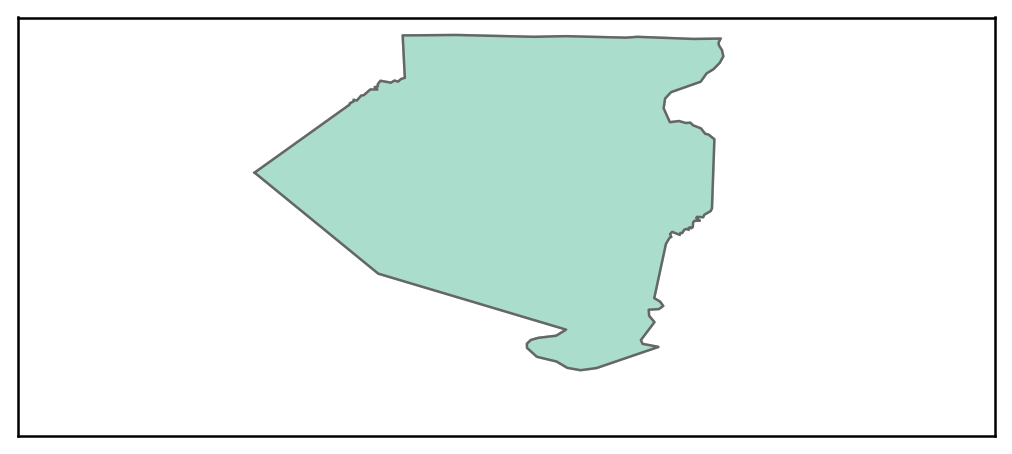

In [230]:
county = shapely.wkt.loads(
    "POLYGON((-80.360782 40.477604,-80.22435999999999 40.57523399999999,-80.224142 40.577117,-80.21917499999999 40.579453,-80.218756 40.582027,-80.214231 40.580883,-80.207978 40.588038,-80.20418099999999 40.58866,-80.194897 40.596772,-80.184753 40.596856,-80.188384 40.600105,-80.18397299999999 40.601328,-80.184151 40.604439,-80.18033299999999 40.609233,-80.165121 40.606542,-80.160343 40.609581,-80.155061 40.608069,-80.150696 40.611884,-80.145383 40.613408,-80.14845099999999 40.67429,-80.071434 40.674935,-79.96077 40.672306,-79.914627 40.673232,-79.828636 40.671073,-79.81183799999999 40.672255,-79.73192399999999 40.669241,-79.692587 40.669732,-79.695594 40.664193,-79.69522599999999 40.660321,-79.69084199999999 40.653329,-79.688777 40.644385,-79.69377999999999 40.635276,-79.702691 40.626023,-79.712807 40.619873,-79.72126999999999 40.607966,-79.76376999999999 40.592966,-79.772285 40.583788,-79.77436999999999 40.569767,-79.76541499999999 40.549854,-79.75238499999999 40.551574,-79.742639 40.548718,-79.73593799999999 40.549176,-79.73235099999999 40.54551499999999,-79.72085899999999 40.541,-79.71463799999999 40.533166,-79.710234 40.53229899999999,-79.701624 40.52544899999999,-79.70509199999999 40.4262,-79.707042 40.422426,-79.715987 40.417319,-79.717698 40.413664,-79.72645 40.414232,-79.727665 40.412495,-79.722365 40.408689,-79.730345 40.408465,-79.73219499999999 40.406003,-79.732528 40.399536,-79.73494199999999 40.397858,-79.73642199999999 40.399391,-79.738692 40.39791,-79.738522 40.395713,-79.74153699999999 40.396866,-79.74470199999999 40.3959,-79.747748 40.391041,-79.750529 40.391124,-79.751262 40.388357,-79.762068 40.392768,-79.765137 40.389468,-79.76338299999999 40.385547,-79.76594299999999 40.38418799999999,-79.77108199999999 40.375419,-79.787853 40.297693,-79.779522 40.292665,-79.774923 40.286489,-79.781199 40.281966,-79.795771 40.281073,-79.795221 40.272368,-79.787542 40.263246,-79.806997 40.237524,-79.804536 40.232101,-79.781761 40.227711,-79.87058499999999 40.197415,-79.89340199999999 40.194343,-79.91258599999999 40.197767,-79.92788299999999 40.206822,-79.95607299999999 40.213582,-79.97020999999999 40.226379,-79.970428 40.232246,-79.964764 40.23767,-79.953788 40.24077399999999,-79.928347 40.243782,-79.91413899999999 40.25251799999999,-80.18346199999999 40.332774,-80.360782 40.477604)),-1"
)
plot(county)

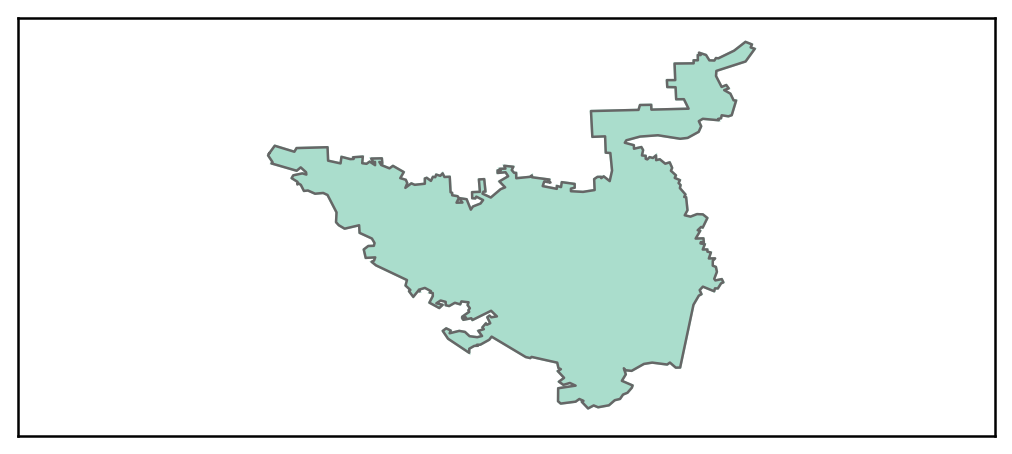

In [231]:
cong = shapely.wkt.loads(
"POLYGON((-80.17660000000001 40.520046,-80.171257 40.527397,-80.15251099999999 40.521677,-80.15043299999999 40.525187,-80.120814 40.52599499999999,-80.120288 40.51314,-80.108363 40.510521,-80.10748099999999 40.516823,-80.099069 40.514623,-80.09590299999999 40.514784,-80.096306 40.516402,-80.087108 40.51706,-80.087678 40.510722,-80.08351999999999 40.510137,-80.080524 40.51226,-80.075357 40.508832,-80.07544999999999 40.51201,-80.076803 40.511503,-80.079054 40.515165,-80.068888 40.515387,-80.06847599999999 40.510725,-80.07132 40.511933,-80.06951599999999 40.508993,-80.06159199999999 40.505803,-80.058289 40.508183,-80.04794799999999 40.502249,-80.051321 40.496462,-80.046014 40.494865,-80.044623 40.49166,-80.04644399999999 40.487163,-80.040712 40.49145499999999,-80.03748999999999 40.490065,-80.027784 40.4911,-80.027795 40.49612399999999,-80.02603499999999 40.496773,-80.022009 40.49382,-80.020079 40.497709,-80.01782999999999 40.497353,-80.01698399999999 40.499834,-80.013029 40.498658,-80.010817 40.501037,-80.009089 40.497531,-80.00402199999999 40.497788,-80.00322 40.48293899999999,-80.001767 40.482428,-80.001683 40.480082,-79.996517 40.479186,-79.995346 40.47736099999999,-79.997545 40.47298199999999,-79.99186 40.473134,-79.99502199999999 40.47736,-79.98787899999999 40.476303,-79.983868 40.466322,-79.981813 40.46934299999999,-79.97457 40.472203,-79.972115 40.475502,-79.97864199999999 40.47882,-79.97956499999999 40.477086,-79.98253099999999 40.477281,-79.982652 40.483063,-79.97515299999999 40.483371,-79.97613699999999 40.495217,-79.97108 40.495511,-79.969854 40.483642,-79.97180899999999 40.483574,-79.97272199999999 40.481629,-79.96475599999999 40.477917,-79.95535099999999 40.485907,-79.951054 40.487655,-79.956559 40.493337,-79.948121 40.498264,-79.95067499999999 40.502113,-79.95826599999999 40.501406,-79.958274 40.503868,-79.95522099999999 40.50396,-79.95620000000001 40.505376,-79.950757 40.505525,-79.951888 40.508252,-79.94322799999999 40.507316,-79.944788 40.504172,-79.942514 40.501529,-79.940547 40.501483,-79.94045 40.496367,-79.927363 40.497671,-79.92549099999999 40.49905,-79.925416 40.497292,-79.908771 40.495104,-79.909324 40.493376,-79.907698 40.492292,-79.91372799999999 40.493278,-79.915182 40.488835,-79.90168 40.486218,-79.90162599999999 40.488985,-79.897604 40.487879,-79.896912 40.492614,-79.884604 40.490922,-79.884592 40.487329,-79.88817499999999 40.48643999999999,-79.8882 40.483948,-79.876632 40.48331599999999,-79.865498 40.485069,-79.865968 40.495515,-79.86281099999999 40.49765,-79.85921599999999 40.497693,-79.85917499999999 40.496435,-79.856864 40.498169,-79.851113 40.493601,-79.84885299999999 40.503658,-79.850494 40.520508,-79.85487999999999 40.520812,-79.85550599999999 40.536414,-79.8677 40.535942,-79.869 40.560554,-79.823584 40.561673,-79.822175 40.566339,-79.811443 40.566534,-79.811297 40.561932,-79.775699 40.562828,-79.78018 40.571933,-79.787578 40.571856,-79.788122 40.583363,-79.79610199999999 40.583532,-79.796437 40.590122,-79.788472 40.59014,-79.78911599999999 40.605965,-79.77085199999999 40.606185,-79.77088999999999 40.609082,-79.76682699999999 40.609072,-79.766941 40.614116,-79.764127 40.614078,-79.765862 40.616422,-79.759051 40.61415,-79.75585699999999 40.60903,-79.751053 40.608855,-79.749571 40.611227,-79.74723999999999 40.61096999999999,-79.73217699999999 40.618303,-79.721358 40.626701,-79.715166 40.624249,-79.716437 40.621374,-79.71247699999999 40.620076,-79.72126999999999 40.607966,-79.74918699999999 40.59897,-79.74952399999999 40.594049,-79.74414 40.58361,-79.739693 40.585438,-79.73738899999999 40.582253,-79.74172 40.580573,-79.73577399999999 40.577203,-79.73272 40.57083,-79.73031999999999 40.5706,-79.73450799999999 40.556646,-79.737706 40.555559,-79.74409799999999 40.556572,-79.744703 40.55371,-79.747466 40.553074,-79.74689499999999 40.551812,-79.76215999999999 40.55319,-79.765946 40.550915,-79.76369799999999 40.546025,-79.766091 40.540713,-79.776618 40.534934,-79.78375299999999 40.534108,-79.80501199999999 40.537455,-79.822086 40.536206,-79.835272 40.532634,-79.83668999999999 40.530259,-79.82806099999999 40.527952,-79.82792599999999 40.524571,-79.82086799999999 40.526167,-79.81921799999999 40.5233,-79.82034399999999 40.518101,-79.816704 40.517793,-79.816726 40.514948,-79.815186 40.514361,-79.812956 40.516513,-79.809754 40.515712,-79.80686799999999 40.518215,-79.806725 40.513625,-79.80327799999999 40.514492,-79.79804799999999 40.510241,-79.79378199999999 40.511553,-79.79145199999999 40.506281,-79.792626 40.503497,-79.78782199999999 40.499134,-79.789006 40.496674,-79.78399499999999 40.49455,-79.78531699999999 40.491744,-79.783395 40.489894,-79.784069 40.486964,-79.77874 40.480864,-79.77991999999999 40.478466,-79.77810699999999 40.478246,-79.776787 40.465825,-79.77942299999999 40.460961,-79.773906 40.459653,-79.76763 40.462069,-79.762074 40.461814,-79.757778 40.458366,-79.762244 40.449183,-79.76373099999999 40.449826,-79.767043 40.446652,-79.764663 40.446079,-79.76899299999999 40.43870099999999,-79.76155 40.438914,-79.761145 40.435353,-79.76399499999999 40.435328,-79.764426 40.434061,-79.760232 40.433285,-79.76218999999999 40.428226,-79.75781599999999 40.428317,-79.75773099999999 40.426185,-79.754431 40.42539499999999,-79.75636799999999 40.419669,-79.750332 40.41979,-79.752602 40.417505,-79.75262599999999 40.412774,-79.749629 40.411578,-79.74866899999999 40.406917,-79.751215 40.400261,-79.75013 40.398674,-79.74400799999999 40.39994799999999,-79.742497 40.396846,-79.74470199999999 40.3959,-79.747748 40.391041,-79.750529 40.391124,-79.751262 40.388357,-79.762068 40.392768,-79.765137 40.389468,-79.76338299999999 40.385547,-79.76594299999999 40.38418799999999,-79.77108199999999 40.375419,-79.783806 40.315441,-79.78795199999999 40.315344,-79.79356299999999 40.320197,-79.79621399999999 40.318319,-79.81050599999999 40.320165,-79.818398 40.3189,-79.83018799999999 40.312264,-79.83616099999999 40.312888,-79.837621 40.314722,-79.835747 40.308922,-79.83953699999999 40.302732,-79.829229 40.298307,-79.82997499999999 40.29615099999999,-79.83415099999999 40.29134699999999,-79.83839399999999 40.289613,-79.841262 40.285437,-79.846277 40.284213,-79.85186999999999 40.279356,-79.862196 40.277468,-79.86643699999999 40.279218,-79.871776 40.276371,-79.87772 40.282598,-79.876178 40.283596,-79.880129 40.285376,-79.883708 40.282836,-79.89791799999999 40.281,-79.900475 40.283211,-79.90037 40.29563,-79.88366599999999 40.298136,-79.889186 40.300709,-79.895365 40.29889,-79.899632 40.301915,-79.89469799999999 40.30558,-79.90074299999999 40.312036,-79.89775299999999 40.313826,-79.900121 40.31504899999999,-79.90125499999999 40.320116,-79.92580199999999 40.325599,-79.92705599999999 40.324479,-79.931315 40.325459,-79.964 40.344991,-79.96626599999999 40.342015,-79.97474199999999 40.337308,-79.97807999999999 40.337205,-79.976969 40.336241,-79.98060000000001 40.336138,-79.985355 40.333426,-79.98542499999999 40.329527,-80.005624 40.342983,-80.01066899999999 40.350452,-80.00738799999999 40.352873,-80.003103 40.35079,-80.004122 40.34816199999999,-79.99491399999999 40.350446,-79.98945999999999 40.349465,-79.98507099999999 40.345372,-79.97775299999999 40.344415,-79.97310299999999 40.345575,-79.97671099999999 40.350503,-79.97141999999999 40.352067,-79.972836 40.353786,-79.969455 40.357692,-79.96844299999999 40.35632,-79.96526799999999 40.35778,-79.96811699999999 40.363483,-79.96600000000001 40.365081,-79.96428999999999 40.363429,-79.95890799999999 40.364305,-79.964472 40.369701,-79.98234099999999 40.360872,-79.983385 40.362562,-79.99098699999999 40.361076,-79.992048 40.362445,-79.988466 40.363282,-79.99218499999999 40.363936,-79.985438 40.368648,-79.986171 40.370241,-79.984762 40.372116,-79.98693 40.375081,-79.98603199999999 40.37782199999999,-79.992881 40.378637,-79.993999 40.375839,-79.999123 40.377344,-80.00457 40.374218,-80.00785999999999 40.374996,-80.00789899999999 40.378237,-80.012738 40.379517,-80.016823 40.376845,-80.010758 40.375365,-80.014037 40.372323,-80.02345099999999 40.377457,-80.020169 40.383733,-80.020219 40.386701,-80.02313099999999 40.38711,-80.02200599999999 40.38849099999999,-80.027778 40.39155,-80.033625 40.389801,-80.032792 40.388242,-80.03450599999999 40.388402,-80.03886399999999 40.383017,-80.04292 40.388366,-80.04159799999999 40.389548,-80.04625 40.393789,-80.044882 40.39906,-80.07444099999999 40.413078,-80.078693 40.416491,-80.076357 40.417603,-80.075199 40.42074,-80.08432599999999 40.420239,-80.08617 40.428282,-80.081869 40.431585,-80.076528 40.431771,-80.075835 40.434462,-80.07840899999999 40.438768,-80.090165 40.444162,-80.090621 40.451419,-80.10447599999999 40.448177,-80.110029 40.451451,-80.11267099999999 40.454359,-80.112189 40.463719,-80.120824 40.48038,-80.124945 40.482303,-80.132696 40.481584,-80.139573 40.484654,-80.143368 40.484247,-80.14634 40.490065,-80.14860399999999 40.491447,-80.149649 40.490364,-80.14952599999999 40.49295,-80.155107 40.49645,-80.153548 40.499137,-80.144876 40.500988,-80.14105599999999 40.49986,-80.14132499999999 40.502123,-80.14644799999999 40.506752,-80.1503 40.503551,-80.174375 40.510525,-80.17344399999999 40.51191499999999,-80.17761 40.518169,-80.17660000000001 40.520046)),-1"
)
plot(cong)

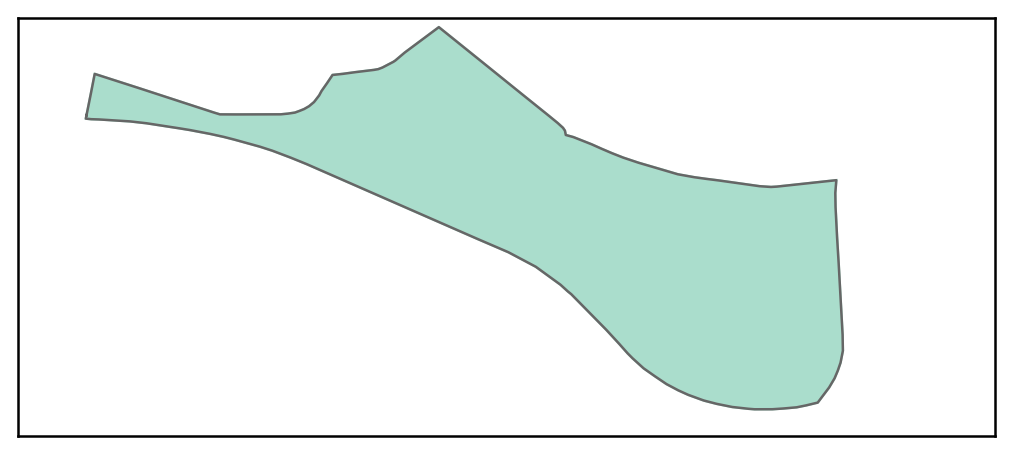

In [233]:
TRACT= shapely.wkt.loads(
"POLYGON ((-79.972894 40.436429, -79.97287399999999 40.436527, -79.972835 40.436725, -79.972807 40.436863, -79.972791 40.436945, -79.97275499999999 40.437122, -79.97264299999999 40.437695, -79.971777 40.437417, -79.97161199999999 40.437365, -79.97127399999999 40.437255, -79.969183 40.436574, -79.96896799999999 40.436504, -79.968796 40.436452, -79.968293 40.43645, -79.96766099999999 40.436451, -79.96699099999999 40.436453, -79.966925 40.436454, -79.966708 40.436475, -79.966492 40.436507, -79.966342 40.436562, -79.96620899999999 40.436616, -79.966059 40.436702, -79.965907 40.436829, -79.96587799999999 40.436865, -79.96574699999999 40.437035, -79.96567399999999 40.43716999999999, -79.96552299999999 40.437385, -79.965504 40.43741199999999, -79.96533599999999 40.437663, -79.965019 40.437697, -79.964635 40.437749, -79.964061 40.437819, -79.963932 40.437842, -79.96380499999999 40.43789, -79.96347 40.438065, -79.963408 40.438106, -79.96319199999999 40.438288, -79.963123 40.438347, -79.96305799999999 40.438396, -79.96207099999999 40.439131, -79.96199 40.439066, -79.961747 40.438872, -79.96166699999999 40.438808, -79.961581 40.438739, -79.961325 40.438533, -79.96123999999999 40.438465, -79.96114999999999 40.438392, -79.96088 40.438174, -79.960791 40.438102, -79.960537 40.43789599999999, -79.959805 40.437304, -79.959777 40.437281, -79.95952299999999 40.437078, -79.95938799999999 40.436969, -79.958984 40.436645, -79.95885 40.436538, -79.958699 40.436415, -79.95841999999999 40.436187, -79.958257 40.436039, -79.958198 40.435953, -79.95817099999999 40.435819, -79.957937 40.435754, -79.95737799999999 40.435533, -79.957185 40.435447, -79.957065 40.435393, -79.956751 40.43525899999999, -79.956603 40.435201, -79.956408 40.43512399999999, -79.95631299999999 40.435092, -79.95603199999999 40.434998, -79.955938 40.434967, -79.955866 40.434946, -79.95564999999999 40.434883, -79.955578 40.434863, -79.9555 40.43484, -79.95526799999999 40.434773, -79.955191 40.434751, -79.95513799999999 40.434735, -79.954982 40.434688, -79.95492999999999 40.434673, -79.95486199999999 40.434652, -79.954729 40.434612, -79.95465899999999 40.434599, -79.95459 40.434587, -79.95431099999999 40.434537, -79.95421999999999 40.434521, -79.95386599999999 40.434472, -79.953497 40.43442599999999, -79.95347099999999 40.434422, -79.95319099999999 40.434383, -79.952995 40.434355, -79.952715 40.434316, -79.95240799999999 40.434272, -79.952213 40.434245, -79.951866 40.434222, -79.951686 40.434233, -79.951369 40.434267, -79.95107299999999 40.434298, -79.95081499999999 40.434326, -79.950467 40.434364, -79.95038799999999 40.434372, -79.95015099999999 40.434398, -79.950073 40.434407, -79.95003 40.434411, -79.94990199999999 40.434425, -79.94986 40.43443, -79.94989099999999 40.434039, -79.949884 40.433609, -79.949837 40.432685, -79.949787 40.431861, -79.94966699999999 40.429679, -79.94965999999999 40.429301, -79.949658 40.429191, -79.94973 40.428825, -79.94981399999999 40.428581, -79.949913 40.428345, -79.950081 40.428062, -79.95043099999999 40.427598, -79.950784 40.427513, -79.951078 40.427453, -79.95146799999999 40.427418, -79.951825 40.427394, -79.952371 40.427393, -79.952561 40.427408, -79.953058 40.427463, -79.95353299999999 40.427559, -79.953751 40.427614, -79.953874 40.427645, -79.953919 40.427659, -79.95397299999999 40.427677, -79.95441199999999 40.427837, -79.954571 40.42791, -79.95462599999999 40.427934, -79.954714 40.427974, -79.954791 40.42801499999999, -79.95484499999999 40.428044, -79.95488999999999 40.428067, -79.95507599999999 40.428166, -79.95525599999999 40.428287, -79.955428 40.428404, -79.95577999999999 40.428651, -79.95612199999999 40.428962, -79.956272 40.429113, -79.956535 40.429409, -79.95692699999999 40.429835, -79.95800299999999 40.430929, -79.958108 40.431014, -79.958333 40.431219, -79.958427 40.431287, -79.958709 40.431492, -79.958803 40.43156099999999, -79.958938 40.431659, -79.959092 40.431771, -79.959774 40.432134, -79.959935 40.432218, -79.960436 40.432433, -79.96060399999999 40.432505, -79.96074899999999 40.432567, -79.960909 40.432637, -79.96182499999999 40.433038, -79.962131 40.433172, -79.96265699999999 40.433401, -79.96303 40.433565, -79.965727 40.434747, -79.96613099999999 40.434924, -79.966531 40.435089, -79.96663199999999 40.435127, -79.967187 40.435337, -79.96732999999999 40.435384, -79.967568 40.43546, -79.968351 40.435677, -79.968672 40.435759, -79.968885 40.435807, -79.969093 40.435852, -79.969584 40.435945, -79.96971099999999 40.43597, -79.970049 40.436025, -79.971054 40.43618, -79.97155699999999 40.436237, -79.972054 40.436269, -79.972314 40.436285, -79.97251399999999 40.436297, -79.97274999999999 40.436305, -79.972916 40.436322, -79.972894 40.436429))"
)
plot(TRACT)

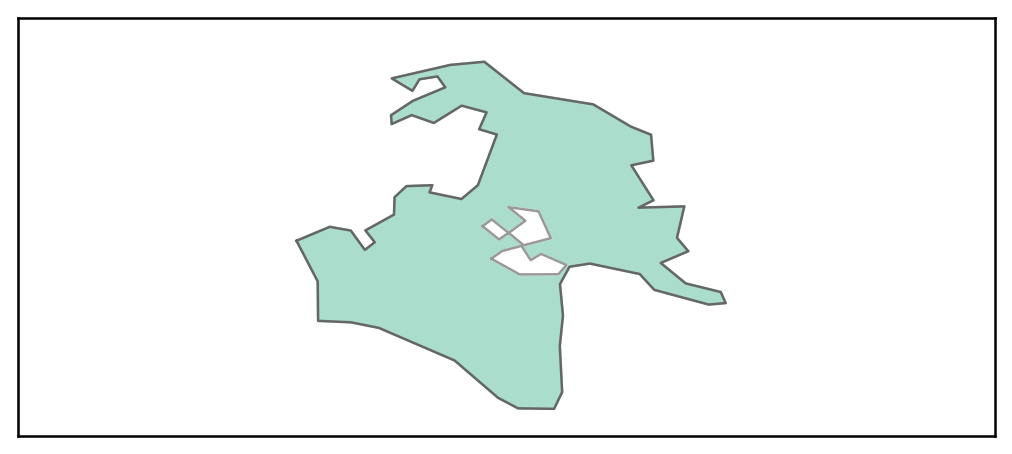

In [234]:
ZCTA= shapely.wkt.loads(
"POLYGON((-79.97504499999999 40.44366,-79.971864 40.444993,-79.969858 40.444632,-79.968513 40.442786,-79.96756499999999 40.443516,-79.96846099999999 40.444649,-79.965728 40.446161,-79.96567399999999 40.447822,-79.96454299999999 40.44888,-79.962074 40.448969,-79.96233699999999 40.448286,-79.959279 40.447648,-79.95770999999999 40.448972,-79.955895 40.453816,-79.957588 40.454319,-79.95687599999999 40.455934,-79.959267 40.456574,-79.961922 40.454923,-79.964034 40.455673,-79.965946 40.454818,-79.96601 40.45565999999999,-79.96390699999999 40.45704,-79.96082699999999 40.45832499999999,-79.961575 40.45937,-79.963295 40.459093,-79.96396799999999 40.457995,-79.96594399999999 40.459178,-79.96034899999999 40.460466,-79.9571 40.460767,-79.9533 40.457766,-79.946685 40.456693,-79.94308199999999 40.454566,-79.94116099999999 40.453793,-79.94094799999999 40.451316,-79.94305 40.450876,-79.94092999999999 40.44753499999999,-79.942365 40.44682299999999,-79.937986 40.446943,-79.93868399999999 40.443937,-79.93760399999999 40.442665,-79.940236 40.44154,-79.93784699999999 40.439583,-79.934494 40.438757,-79.934033 40.437707,-79.935648 40.437563,-79.94084599999999 40.438967,-79.94224299999999 40.440482,-79.94700899999999 40.441483,-79.948953 40.44118,-79.949865 40.439517,-79.94958099999999 40.436505,-79.949884 40.433609,-79.949658 40.429191,-79.95043099999999 40.427598,-79.953874 40.427645,-79.95577999999999 40.428651,-79.959935 40.432218,-79.967187 40.435337,-79.969859 40.435869,-79.97298099999999 40.436007,-79.97301999999999 40.43978,-79.97504499999999 40.44366),(-79.95643799999999 40.441949,-79.953722 40.44044299999999,-79.952502 40.440445,-79.95001499999999 40.440461,-79.94924399999999 40.441345,-79.95167499999999 40.442408,-79.95265999999999 40.441809,-79.95354499999999 40.443175,-79.955389 40.442684,-79.95643799999999 40.441949),(-79.957268 40.445052,-79.955686 40.443782,-79.954959 40.44429299999999,-79.954776 40.444418,-79.95509699999999 40.444674,-79.95638 40.44570299999999,-79.957268 40.445052),(-79.954776 40.444418,-79.954483 40.444184,-79.953335 40.443227,-79.95074 40.443908,-79.951911 40.446476,-79.95478199999999 40.446871,-79.95317299999999 40.445574,-79.954605 40.444532,-79.954776 40.444418)),4326"
)
plot(ZCTA)

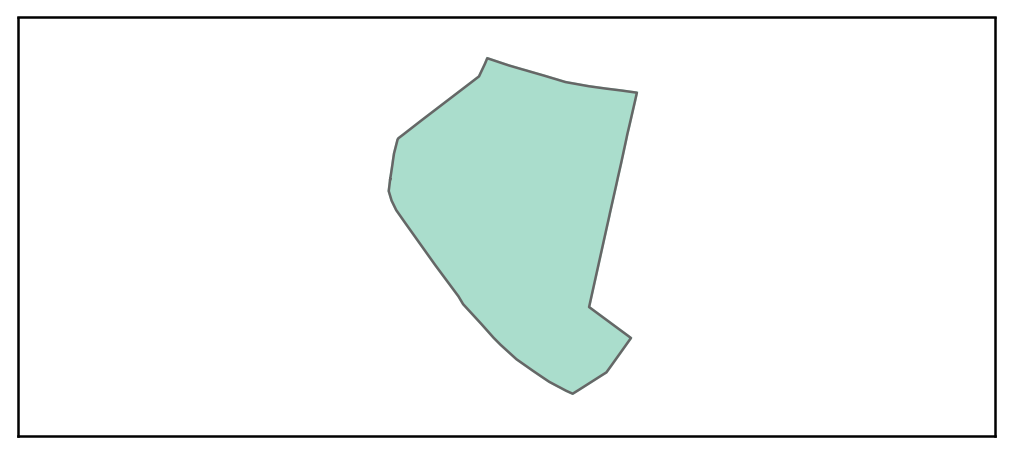

In [235]:
plot(CBG)

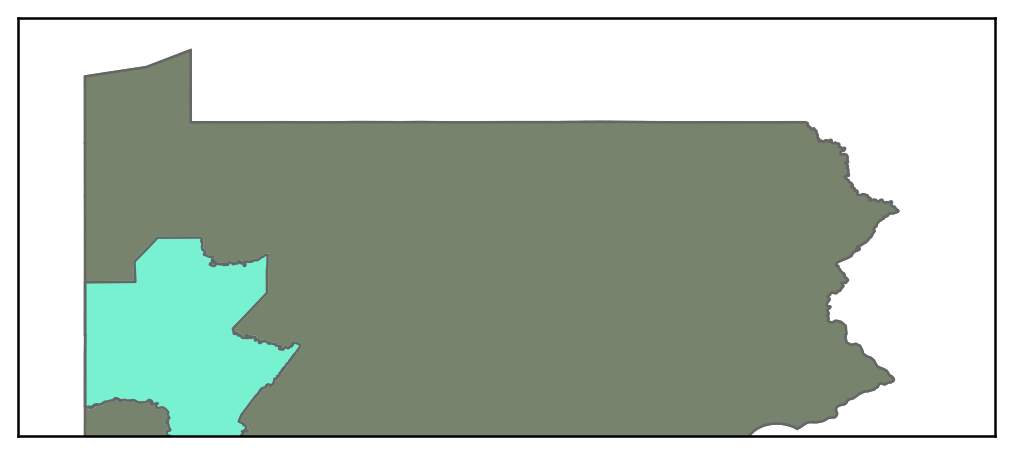

In [241]:
PA = state_dict["Pennsylvania"]
plot([PA, CBSA], color_dict=None)

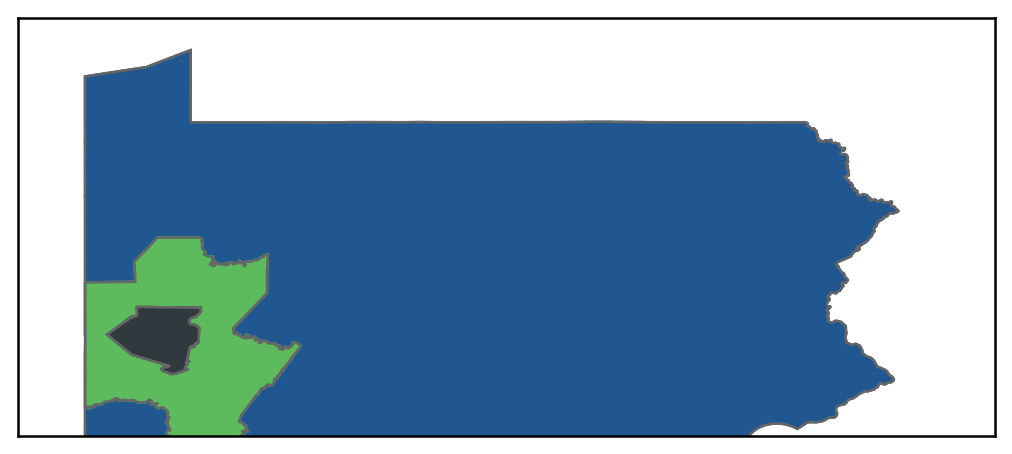

In [242]:

plot([PA, CBSA, county], color_dict=None)

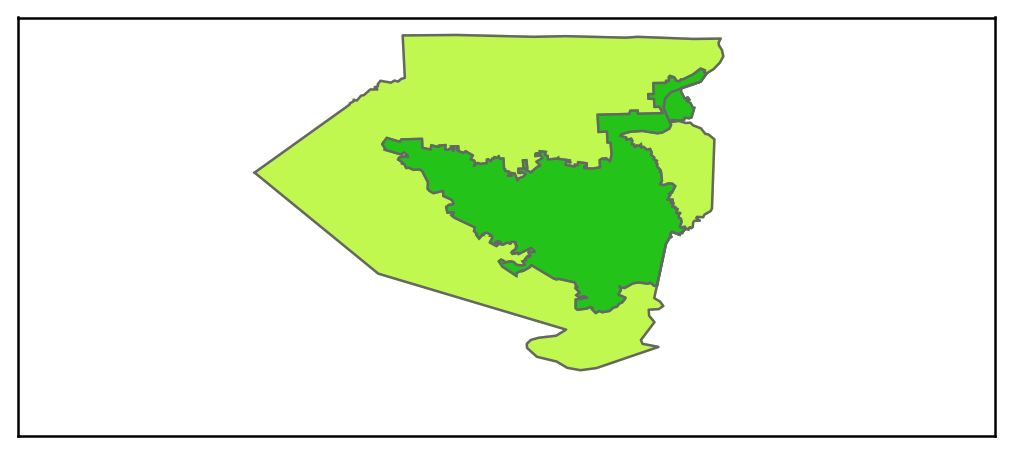

In [244]:
plot([county, cong], color_dict=None)

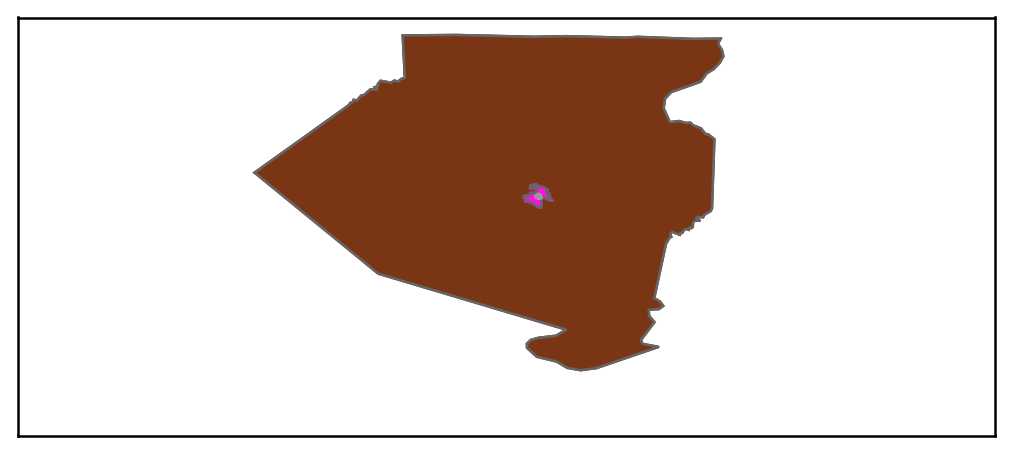

In [245]:
plot([county, ZCTA], color_dict=None)

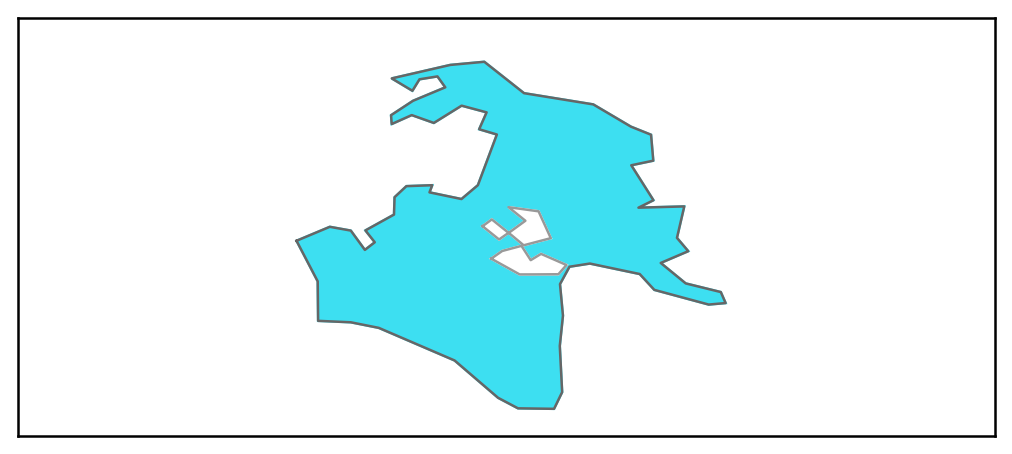

In [246]:
plot([ZCTA], color_dict=None)

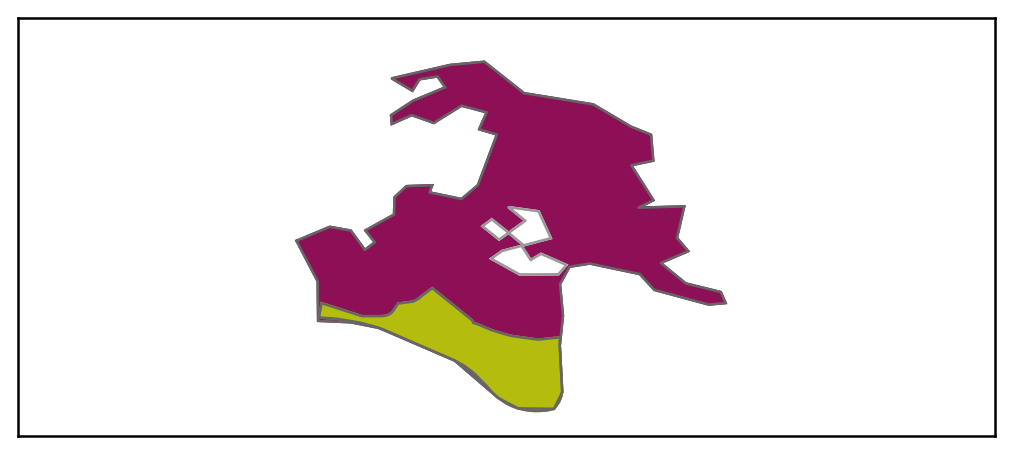

In [247]:
plot([ZCTA, TRACT], color_dict=None)

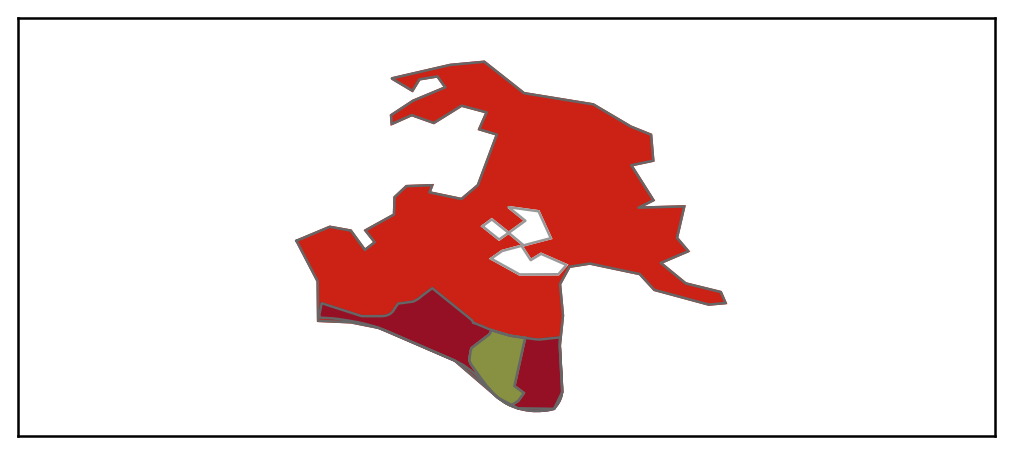

In [251]:
plot([ZCTA, TRACT, CBG], color_dict=None)

## Any questions?

## Thanks!!